In [1]:
import pandas as pd
from Bio.SeqUtils.ProtParam import ProteinAnalysis,ProtParamData
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib_venn import venn2
import os
from scipy import stats
from scipy.ndimage import gaussian_filter1d
from matplotlib.ticker import PercentFormatter

In [ ]:
os.mkdir("GST_Figures")

In [3]:
GST = pd.read_csv("ALL_GST.csv")

In [4]:
import re
W_RPattern = re.compile(r'W\wR')
Y_CPattern = re.compile(r'(Y\wC)|(YY\w)')
WG_GPattern = re.compile(r'(WG\wG)|(W\wQG)|(\wGQG)|(\w\wQG)|(WG\w\w)|(W\w\wG)|(W\wQ\w)')
def find_cdr1(sequence):
    # STARTING POS. OF CDR1:
    left_area = sequence[20:26]  # look from pos. 20 - 26 of seq (0-based)
    left_cdr = -1
    la_i = left_area.find('SC')
    if la_i < 0:
        # didn't find 'SC', look for 'C'
        la_i = left_area.find('C')
    else:
        la_i += 1  # 'C' is our marker, so advance past 'S'
    if la_i >= 0:
        left_cdr = la_i + 20 + 5  # CDR1 starts at 'C' + 5 (add 20 to put it back in the full sequence)

    # ENDING POS. OF CDR1:
    right_area = sequence[32:40]  # look from pos. 32 - 40 of seq (0-based)
    ra_i = -1
    right_cdr = -1
    W_R = W_RPattern.search(right_area)
    if W_R != None:
        # if we found 'WXR', find its index
        ra_i = right_area.find(W_R[0])

    else:
        ra_i = right_area.find('W')  # didn't find 'WXR', look for 'W'
    if ra_i >= 0:
        right_cdr = ra_i + 32 - 1 + 1  # CDR1 ends at 'W' - 1 (add 32 to put it back in the full sequence)

    # check if st/end found and if not follow rules:
    if left_cdr == -1 and right_cdr == -1:
        left_cdr = 28
        right_cdr = 36
    elif left_cdr == -1:
        left_cdr = right_cdr - 8
    elif right_cdr == -1:
        right_cdr = left_cdr + 8

    return [left_cdr,right_cdr]

def find_cdr2(sequence):
    # STARTING POS. OF CDR2:
    left_area = sequence[32:40]  # look from pos. 32 - 40 of seq (0-based)
    la_i = -1
    left_cdr = -1
    W_R = W_RPattern.search(left_area)
    if W_R != None:
        # if we found 'WXR', find its index
        la_i = W_R.start(0)
    else:
        la_i = left_area.find('W')  # didn't find 'WXR', look for 'W'
    if la_i >= 0:
        left_cdr = la_i + 32 + 14  # CDR2 starts at 'W' + 14 (add 32 to put it back in the full sequence)

    # ENDING POS. OF CDR2:
    right_area = sequence[63:72]  # look from pos. 63 - 72 of seq (0-based)
    right_cdr = -1
    ra_i = right_area.find('RF')
    if ra_i >= 0:
        right_cdr = ra_i + 63 - 8 + 1  # CDR2 ends at 'R' - 8 (add 63 to put it back in the full sequence)

    # check if st/end found and if not follow rules:
    if left_cdr == -1 and right_cdr == -1:
        left_cdr = 51
        right_cdr = 60
    elif left_cdr == -1:
        left_cdr = right_cdr - 9
    elif right_cdr == -1:
        right_cdr = left_cdr + 9

    return [left_cdr,right_cdr]

def find_cdr3(sequence):
    left_area = sequence[90:105]
    la_i = -1
    left_cdr = -1
    Y_C = Y_CPattern.search(left_area)
    if Y_C != None:
        # if we found 'YXR', find its index
        la_i = Y_C.start(0)+2
    else:
        la_i = left_area.find('C')  # didn't find 'YXC', look for 'C'

    if la_i >= 0:
        left_cdr = la_i + 90 + 3
    n = len(sequence) - 1
    n1 = n - 14
    subtract_amount = 1
    right_area = sequence[n1:n - 4]
    ra_i = -1
    right_cdr = -1
    WG_G = WG_GPattern.search(right_area)
    if WG_G != None:
        ra_i = WG_G.start(0)

    if ra_i >= 0:
        right_cdr = ra_i + n1 - subtract_amount + 1  # CDR3 ends at 'W' - 1 (or 'Q' - 3) (add n-14 to put it back in the full sequence)
    # check
    if left_cdr == -1 and right_cdr == -1:
        left_cdr = n - 21
        right_cdr = n - 10
    elif left_cdr == -1:
        left_cdr = right_cdr - 11
    elif right_cdr == -1:
        if left_cdr + 11 <= n:
            right_cdr = left_cdr + 11
        else:
            right_cdr = n
    if left_cdr > right_cdr:
        left_cdr = n - 1
        right_cdr = n
    return [left_cdr,right_cdr]

def find_cdr1_seq(x):
    cdr1 = find_cdr1(x)
    return x[cdr1[0]:cdr1[1]]
def find_cdr2_seq(x):
    cdr2 = find_cdr2(x)
    return x[cdr2[0]:cdr2[1]]
def find_cdr3_seq(x):
    cdr3 = find_cdr3(x)
    return x[cdr3[0]:cdr3[1]]
def find_fr1_seq(x):
    cdr1_start = find_cdr1(x)[0]
    return x[:cdr1_start]

def find_fr2_seq(x):
    cdr1_end = find_cdr1(x)[1]
    cdr2_start = find_cdr2(x)[0]
    return x[cdr1_end:cdr2_start]

def find_fr3_seq(x):
    cdr2_end = find_cdr2(x)[1]
    cdr3_start = find_cdr3(x)[0]
    
    return x[cdr2_end:cdr3_start]

def find_fr4_seq(x):
    cdr3_end = find_cdr3(x)[1]
    return x[cdr3_end:]

def extract_more_cdr3_region(sequence,cdr3):
    start,end  = re.search(cdr3,sequence).span(0)
    return sequence[start - 5:end+4]

In [5]:
GST['CDR1'] = GST['Sequence'].apply(lambda x: find_cdr1_seq(x))
GST['CDR2'] = GST['Sequence'].apply(lambda x: find_cdr2_seq(x))
GST['CDR3'] = GST['Sequence'].apply(lambda x: find_cdr3_seq(x))

## GST CDR3 for Phylogenetic Tree

In [77]:
Unique_CDR3 = GST.drop_duplicates("CDR3")
Unique_CDR3['YYC_CDR3'] = Unique_CDR3['CDR3'].apply(lambda x: "YYCAA" + x +"WGQG")
Unique_CDR3['real_YYC_CDR3'] = Unique_CDR3.apply(lambda x: extract_more_cdr3_region(x['Sequence'],x['CDR3']),1)
Unique_CDR3['CDR3 PI'] = Unique_CDR3['CDR3'].apply(lambda x: ProteinAnalysis(x).isoelectric_point())
Unique_CDR3['CDR3 Length'] = Unique_CDR3['CDR3'].apply(lambda x: len(x))
Unique_CDR3['CDR3 Cysteine'] = Unique_CDR3['CDR3'].apply(lambda x: x.count("C"))
Unique_CDR3['CDR3 Hydrophobicity'] = Unique_CDR3['CDR3'].apply(lambda x: ProteinAnalysis(x).gravy())
max_hydro = Unique_CDR3['CDR3 Hydrophobicity'].max()
min_hydro = Unique_CDR3['CDR3 Hydrophobicity'].min()
Unique_CDR3['Normalized CDR3 Hydrophobicity'] = 2* (Unique_CDR3['CDR3 Hydrophobicity'] - min_hydro)/(max_hydro-min_hydro) -1
max_pi = Unique_CDR3['CDR3 PI'].max()
min_pi = Unique_CDR3['CDR3 PI'].min()
Unique_CDR3['Normalized CDR3 PI'] = 2* (Unique_CDR3['CDR3 PI'] - min_pi)/(max_pi-min_pi) -1

Unique_CDR3.to_csv("GST_Unique_CDR3_property.csv")

c:\users\shi lab\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\shi lab\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\shi lab\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying t

## Identification Summary

In [6]:
print("Unique CDR3:{}".format(GST['CDR3'].unique().shape[0]))
print("Unique CDR:{}".format(GST[['CDR1','CDR2','CDR3']].apply(lambda x: '-'.join(x.values),1).unique().shape[0]))
print("Unique Seq:{}".format(GST.shape[0]))

Unique CDR3:3453
Unique CDR:9915
Unique Seq:65124


## HighpH Sequence Property

In [8]:
GST['Sequence PI'] = GST['Sequence'].apply(lambda x: ProteinAnalysis(x).isoelectric_point())
GST['Sequence Hydropathy'] = GST['Sequence'].apply(lambda x: ProteinAnalysis(x).gravy())
GST['CDR1 PI'] = GST['CDR1'].apply(lambda x: ProteinAnalysis(x).isoelectric_point())
GST['CDR2 PI'] = GST['CDR2'].apply(lambda x: ProteinAnalysis(x).isoelectric_point())
GST['CDR3 PI'] = GST['CDR3'].apply(lambda x: ProteinAnalysis(x).isoelectric_point())
GST['CDR1 Hydropathy'] = GST['CDR1'].apply(lambda x: ProteinAnalysis(x).gravy())
GST['CDR2 Hydropathy'] = GST['CDR2'].apply(lambda x: ProteinAnalysis(x).gravy())
GST['CDR3 Hydropathy'] = GST['CDR3'].apply(lambda x: ProteinAnalysis(x).gravy())

In [94]:
GST.to_csv("GST.csv")

## HighpH Low Affinity Vs HighpH Affinity Sequence property comparison

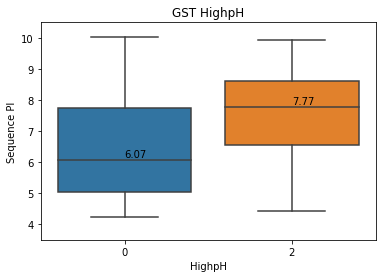

In [8]:
sns.boxplot(x = 'HighpH',y='Sequence PI',data = GST[(GST['HighpH']=='0')|(GST['HighpH']=='2')])
plt.ylim((3.5,10.5))
plt.title("GST HighpH")
low_median = GST[GST['HighpH']=='0']['Sequence PI'].median()
high_median = GST[GST['HighpH']=='2']['Sequence PI'].median()

plt.text(0,low_median+0.1,str(round(low_median,2)))
plt.text(1,high_median+0.1,str(round(high_median,2)))

plt.savefig("GST_Figures/Sequence PI.svg",format='svg')

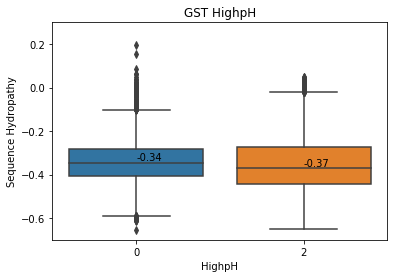

In [9]:
sns.boxplot(x = 'HighpH',y='Sequence Hydropathy',data = GST[(GST['HighpH']=='0')|(GST['HighpH']=='2')])
plt.ylim((-0.7,0.3))
low_median = GST[GST['HighpH']=='0']['Sequence Hydropathy'].median()
high_median = GST[GST['HighpH']=='2']['Sequence Hydropathy'].median()

plt.text(0,low_median+0.01,str(round(low_median,2)))
plt.text(1,high_median+0.01,str(round(high_median,2)))
plt.title("GST HighpH")
plt.savefig("GST_Figures/Sequence Hydropathy.svg",format='svg')

# Unique HighpH CDR Feature

In [9]:
GST['CDR'] = GST[['CDR1','CDR2','CDR3']].apply(lambda x: "".join(x.values),1)
HighpH = GST[GST['HighpH']!='/']
Unique_CDR_HighpH = HighpH.drop_duplicates("CDR")
Unique_CDR_HighpH['CDR PI'] = Unique_CDR_HighpH['CDR'].apply(lambda x: ProteinAnalysis(x).isoelectric_point())

c:\users\shi lab\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [107]:
Unique_CDR_HighpH.to_csv("GST_Unique_CDR_HighpH.csv")

In [2]:
Unique_CDR_HighpH = pd.read_csv("GST_Unique_CDR_HighpH.csv")

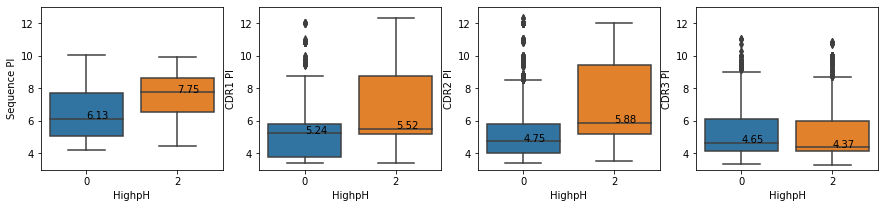

In [8]:
plt.figure(figsize=(15,3))
plt.subplot(141)
sns.boxplot(x = 'HighpH',y='Sequence PI',data = Unique_CDR_HighpH[(Unique_CDR_HighpH['HighpH']==0)|(Unique_CDR_HighpH['HighpH']==2)])
plt.ylim((3,13))
low_median = Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']==0]['Sequence PI'].median()
high_median = Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']==2]['Sequence PI'].median()
plt.text(0,low_median+0.01,str(round(low_median,2)))
plt.text(1,high_median+0.01,str(round(high_median,2)))

plt.subplot(142)
sns.boxplot(x = 'HighpH',y='CDR1 PI',data = Unique_CDR_HighpH[(Unique_CDR_HighpH['HighpH']==0)|(Unique_CDR_HighpH['HighpH']==2)])
plt.ylim((3,13))
low_median = Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']==0]['CDR1 PI'].median()
high_median = Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']==2]['CDR1 PI'].median()
plt.text(0,low_median+0.01,str(round(low_median,2)))
plt.text(1,high_median+0.01,str(round(high_median,2)))

plt.subplot(143)
sns.boxplot(x = 'HighpH',y='CDR2 PI',data = Unique_CDR_HighpH[(Unique_CDR_HighpH['HighpH']==0)|(Unique_CDR_HighpH['HighpH']==2)])
plt.ylim((3,13))
low_median = Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']==0]['CDR2 PI'].median()
high_median = Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']==2]['CDR2 PI'].median()
plt.text(0,low_median+0.01,str(round(low_median,2)))
plt.text(1,high_median+0.01,str(round(high_median,2)))

plt.subplot(144)
sns.boxplot(x = 'HighpH',y='CDR3 PI',data = Unique_CDR_HighpH[(Unique_CDR_HighpH['HighpH']==0)|(Unique_CDR_HighpH['HighpH']==2)])
plt.ylim((3,13))
low_median = Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']==0]['CDR3 PI'].median()
high_median =Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']==2]['CDR3 PI'].median()
plt.text(0,low_median+0.01,str(round(low_median,2)))
plt.text(1,high_median+0.01,str(round(high_median,2)))
plt.savefig("GST_Figures/GST_Nb_CDR_PI.svg",format="svg")

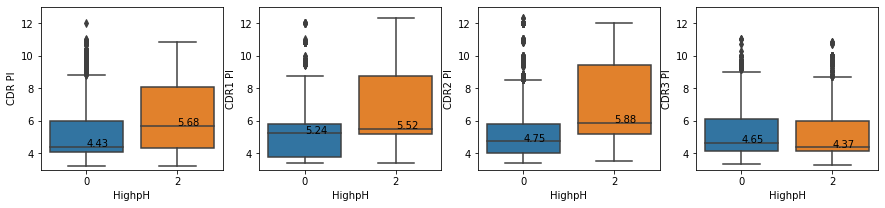

In [11]:
plt.figure(figsize=(15,3))
plt.subplot(141)
sns.boxplot(x = 'HighpH',y='CDR PI',data = Unique_CDR_HighpH[(Unique_CDR_HighpH['HighpH']=='0')|(Unique_CDR_HighpH['HighpH']=='2')])
plt.ylim((3,13))
low_median = Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='0']['CDR PI'].median()
high_median = Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='2']['CDR PI'].median()
plt.text(0,low_median+0.01,str(round(low_median,2)))
plt.text(1,high_median+0.01,str(round(high_median,2)))

plt.subplot(142)
sns.boxplot(x = 'HighpH',y='CDR1 PI',data = Unique_CDR_HighpH[(Unique_CDR_HighpH['HighpH']=='0')|(Unique_CDR_HighpH['HighpH']=='2')])
plt.ylim((3,13))
low_median = Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='0']['CDR1 PI'].median()
high_median = Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='2']['CDR1 PI'].median()
plt.text(0,low_median+0.01,str(round(low_median,2)))
plt.text(1,high_median+0.01,str(round(high_median,2)))

plt.subplot(143)
sns.boxplot(x = 'HighpH',y='CDR2 PI',data = Unique_CDR_HighpH[(Unique_CDR_HighpH['HighpH']=='0')|(Unique_CDR_HighpH['HighpH']=='2')])
plt.ylim((3,13))
low_median = Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='0']['CDR2 PI'].median()
high_median = Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='2']['CDR2 PI'].median()
plt.text(0,low_median+0.01,str(round(low_median,2)))
plt.text(1,high_median+0.01,str(round(high_median,2)))

plt.subplot(144)
sns.boxplot(x = 'HighpH',y='CDR3 PI',data = Unique_CDR_HighpH[(Unique_CDR_HighpH['HighpH']=='0')|(Unique_CDR_HighpH['HighpH']=='2')])
plt.ylim((3,13))
low_median = Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='0']['CDR3 PI'].median()
high_median =Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='2']['CDR3 PI'].median()
plt.text(0,low_median+0.01,str(round(low_median,2)))
plt.text(1,high_median+0.01,str(round(high_median,2)))
plt.savefig("GST_Figures/GST_CDR_PI.svg",format="svg")

### CDR3 Head Region AA Composition

In [10]:
Unique_CDR_HighpH['Head_CDR3'] = Unique_CDR_HighpH['CDR3'].apply(lambda x: x[:-4])
Unique_CDR_HighpH['Head_CDR3 PI'] = Unique_CDR_HighpH['Head_CDR3'].apply(lambda x: ProteinAnalysis(x).isoelectric_point() if x!="" else 0)
for aa in 'GASPVTCILNDQKEMHFRYW':
    Unique_CDR_HighpH['head_'+aa] = Unique_CDR_HighpH['Head_CDR3'].apply(lambda x: x.count(aa))
for aa in 'GASPVTCILNDQKEMHFRYW':
    Unique_CDR_HighpH[aa] = Unique_CDR_HighpH['CDR3'].apply(lambda x: x.count(aa))

c:\users\shi lab\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\shi lab\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\shi lab\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

### Amino acid concentration change


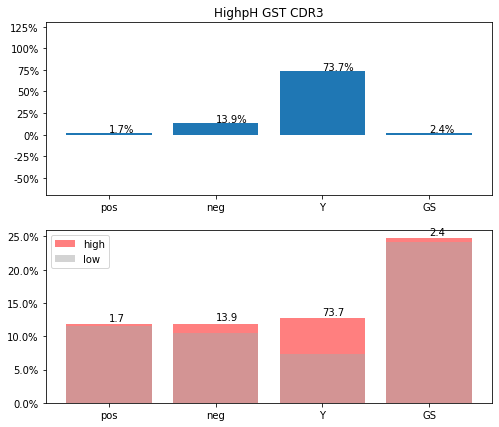

In [39]:

plt.figure(figsize=(8,7))
plt.subplot(211)
plt.title("HighpH GST CDR3")

high = Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='2'][["head_"+aa for aa in 'GASCDPNTEVQHMILKRFYW']].sum(0)/Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='2']['CDR3'].apply(lambda x:len(x)-4).sum()
low = Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='0'][["head_"+aa for aa in 'GASCDPNTEVQHMILKRFYW']].sum(0)/Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='0']['CDR3'].apply(lambda x:len(x)-4).sum()
low['pos'] = low[['head_K','head_R','head_H']].sum()
low['neg'] = low[['head_D','head_E']].sum()
low['Y'] = low[['head_Y']].sum()
low['GS'] =  low[['head_G','head_S']].sum()


high['pos'] = high[['head_K','head_R','head_H']].sum()
high['neg'] = high[['head_D','head_E']].sum()
high['Y'] = high[['head_Y']].sum()
high['GS'] =  high[['head_G','head_S']].sum()


selected_low = low.loc[['pos','neg','Y',"GS"]]
selected_aas_in_low = selected_low.index
selected_high = high.loc[selected_aas_in_low]

diff = ((selected_high-selected_low)/selected_low)
plt.bar(diff.index,diff.values)
plt.ylim((-0.7,1.3))
for aa in diff.index:
    plt.text(aa,diff.loc[aa]+0.01,"{}%".format(round(100*diff.loc[aa],1)))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#plt.savefig("Concentration_head_cdr3_percentage_change.svg",format='svg')


data = pd.DataFrame({"aa":selected_low.index,"high":selected_high.values,"low":selected_low.values})
data['diff'] = (data['high']-data['low'])/data['low']
#data.sort_values('diff',ascending=True,inplace=True)
#sns.barplot(x='aa',y='high',data=data,color='red',alpha=0.5,label='High')
#sns.barplot(x='aa',y='low',data=data,color='grey',alpha=0.5,label='Low')
plt.subplot(212)
plt.bar(data['aa'],data['high'],color='red',alpha=0.5,label='high')
plt.bar(data['aa'],data['low'],color='darkgrey',alpha=0.5,label='low')

for i,r in data.iterrows():
    plt.text(r['aa'],(r['high'] if r['high']>r['low'] else r['low'] )+0.005,round(r['diff']*100,1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
plt.savefig("GST_Figures/GST_CDR3_AA_group_Concentration(Unique CDR).svg",format='svg')

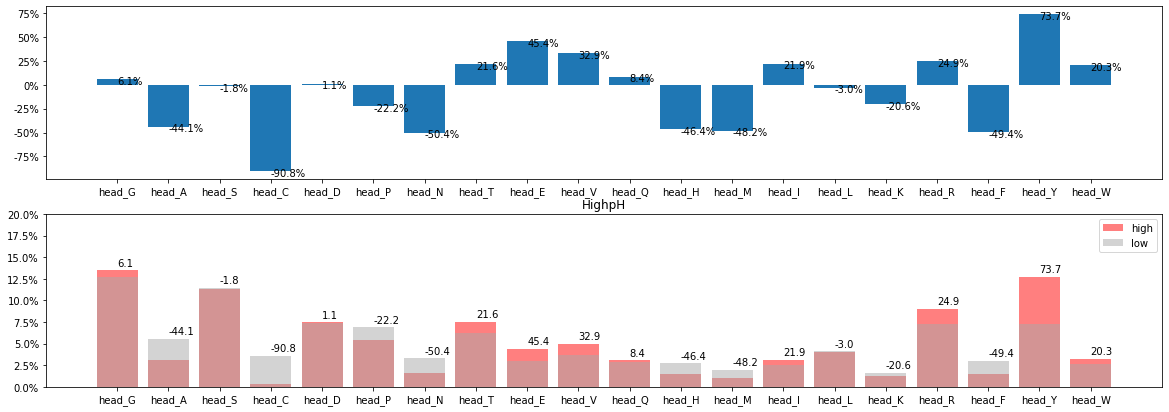

In [82]:

plt.figure(figsize=(20,7))
plt.subplot(211)

high = Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='2'][["head_"+aa for aa in 'GASCDPNTEVQHMILKRFYW']].sum(0)/Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='2']['CDR3'].apply(lambda x:len(x)-4).sum()
low = Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='0'][["head_"+aa for aa in 'GASCDPNTEVQHMILKRFYW']].sum(0)/Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='0']['CDR3'].apply(lambda x:len(x)-4).sum()
selected_low = low.loc[low.index.map(low>0)]
selected_aas_in_low = selected_low.index
selected_high = high.loc[selected_aas_in_low]

diff = ((selected_high-selected_low)/selected_low)
plt.bar(diff.index,diff.values)
for aa in diff.index:
    plt.text(aa,diff.loc[aa]-0.05,"{}%".format(round(100*diff.loc[aa],1)))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
#plt.savefig("ALL_Concentration_head_cdr3_percentage_change.svg",format='svg')
plt.subplot(212)


data = pd.DataFrame({"aa":selected_low.index,"high":selected_high.values,"low":selected_low.values})
data['diff'] = (data['high']-data['low'])/data['low']
#data.sort_values('diff',ascending=True,inplace=True)
#sns.barplot(x='aa',y='high',data=data,color='red',alpha=0.5,label='High')
#sns.barplot(x='aa',y='low',data=data,color='grey',alpha=0.5,label='Low')
plt.bar(data['aa'],data['high'],color='red',alpha=0.5,label='high')
plt.bar(data['aa'],data['low'],color='darkgrey',alpha=0.5,label='low')

for i,r in data.iterrows():
    plt.text(r['aa'],(r['high'] if r['high']>r['low'] else r['low'] )+0.005,round(r['diff']*100,1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("HighpH")
plt.legend()
plt.ylim(ymax=0.2)

plt.savefig("GST_Figures/GST_CDR3_AA_Concentration(Unique CDR).svg",format='svg')

In [26]:
def counts(data):
    aa_counts = (data[["head_"+aa for aa in 'GASCDPNTEVQHMILKRFYW']].sum(0)/data['CDR3'].apply(lambda x:len(x)-4).sum()).sort_values(ascending=False)
    AAs = aa_counts.index
    AA_Counts = aa_counts.values
    
    return [AAs,AA_Counts]

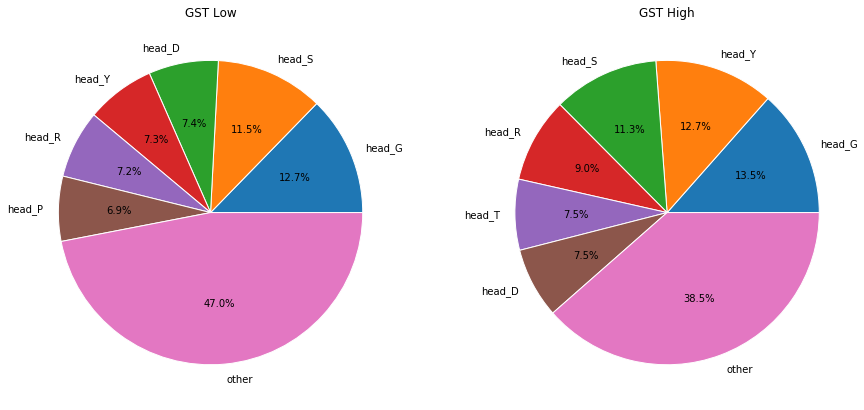

In [28]:
plt.figure(figsize=(15,8))
plt.subplot(121)
aa,aa_counts = counts(Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='0'])

plt.pie(
    list(aa_counts[:6]) + [aa_counts[6:].sum()],
    labels =list(aa[:6]) + ['other'],
    radius=1,
    wedgeprops=dict(width=1, edgecolor='w'),
autopct= "%1.1f%%")
plt.title("GST Low")
plt.subplot(122)
aa,aa_counts = counts(Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='2'])

plt.pie(
    list(aa_counts[:6]) + [aa_counts[6:].sum()],
    labels =list(aa[:6]) + ['other'],
    radius=1,
    wedgeprops=dict(width=1, edgecolor='w'),
autopct= "%1.1f%%")
plt.title("GST High")
plt.savefig("GST_Figures/PieChart GST AA percentage(Unique CDR).svg",format='svg')

### Y  G  S position

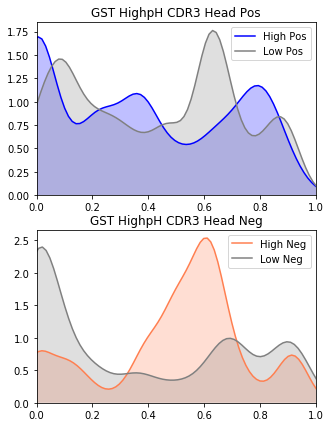

In [29]:
high_p=[]
high_n=[]

for cdr3 in Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='2']['CDR3']:
    if not ("R" in cdr3 or "K" in cdr3):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='K' or res =='R':
                pos.append(i/(len(cdr3)-4))dd

    high_p += pos
    
for cdr3 in Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='2']['CDR3']:
    if not ("D" in cdr3 or "E" in cdr3):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='D' or res =='E':
                pos.append(i/(len(cdr3)-4))

    high_n += pos
low_p=[]
low_n=[]

for cdr3 in Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='0']['CDR3']:
    if not ("R" in cdr3 or "K" in cdr3 ):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='K' or res =='R':
                pos.append(i/(len(cdr3)-4))

    low_p += pos
    
for cdr3 in Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='0']['CDR3']:
    if not ("D" in cdr3 or "E" in cdr3):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='D' or res =='E':
                pos.append(i/(len(cdr3)-4))

    low_n += pos
plt.figure(figsize=(5,7))
plt.subplot(211)
plt.title("GST HighpH CDR3 Head Pos")
sns.distplot(high_p,hist=False,label='High Pos',kde_kws={'shade':True},color='blue')
sns.distplot(low_p,hist=False,label='Low Pos',kde_kws={'shade':True},color='grey')

plt.xlim((0,1))
plt.subplot(212)
plt.title("GST HighpH CDR3 Head Neg")
sns.distplot(high_n,hist=False,label='High Neg',kde_kws={'shade':True},color='coral')
sns.distplot(low_n,hist=False,label='Low Neg',kde_kws={'shade':True},color='grey')
plt.xlim((0,1))
plt.legend()
plt.savefig("GST_Figures\GST_Charge_CDR3_head_position(Unique CDR).svg",format='svg')

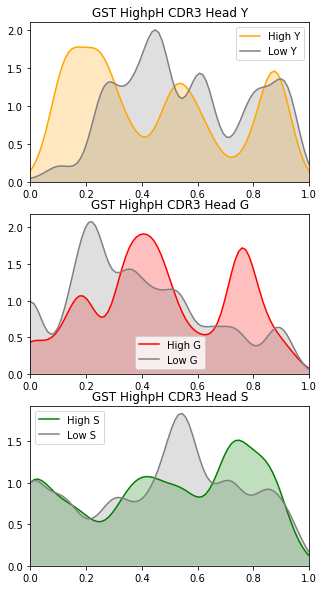

In [30]:
high_G=[]
high_Y=[]
high_S=[]
for cdr3 in Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='2']['CDR3']:
    if not ("Y" in cdr3):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='Y':
                pos.append(i/(len(cdr3)-4))

    high_Y += pos
for cdr3 in Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='2']['CDR3']:
    if not ("G" in cdr3):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='G':
                pos.append(i/(len(cdr3)-4))

    high_G += pos
for cdr3 in Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='2']['CDR3']:
    if not ("S" in cdr3):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='S':
                pos.append(i/(len(cdr3)-4))

    high_S += pos

low_G=[]
low_Y=[]
low_S=[]

for cdr3 in Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='0']['CDR3']:
    if not ("Y" in cdr3):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='Y':
                pos.append(i/(len(cdr3)-4))

    low_Y += pos
for cdr3 in Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='0']['CDR3']:
    if not ("G" in cdr3):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='G':
                pos.append(i/(len(cdr3)-4))

    low_G += pos
for cdr3 in Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='0']['CDR3']:
    if not ("S" in cdr3):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='S':
                pos.append(i/(len(cdr3)-4))

    low_S += pos

plt.figure(figsize=(5,10))
plt.subplot(311)
plt.title("GST HighpH CDR3 Head Y")

sns.distplot(high_Y,hist=False,label='High Y',kde_kws={'shade':True},color='orange')
sns.distplot(low_Y,hist=False,label='Low Y',kde_kws={'shade':True},color='grey')

plt.xlim((0,1))
plt.subplot(312)
plt.title("GST HighpH CDR3 Head G")
sns.distplot(high_G,hist=False,label='High G',kde_kws={'shade':True},color='red')
sns.distplot(low_G,hist=False,label='Low G',kde_kws={'shade':True},color='grey')

plt.xlim((0,1))
plt.legend()
#plt.savefig("HSA_Figures\HSA_YGS_CDR3_head_position.svg",format='svg')
plt.subplot(313)
plt.title("GST HighpH CDR3 Head S")

sns.distplot(high_S,hist=False,label='High S',kde_kws={'shade':True},color='green')
sns.distplot(low_S,hist=False,label='Low S',kde_kws={'shade':True},color='grey')
plt.xlim((0,1))
plt.legend()
plt.savefig("GST_Figures\GST_YGS_CDR3_head_position(Unique CDR).svg",format='svg')

## CDR1 Amino acid Composition

In [11]:
High_CDR1_Unique_CDR_HighpH = Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='2']
Low_CDR1_Unique_CDR_HighpH = Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='0']

In [12]:
for aa in 'GASPVTCILNDQKEMHFRYW':
    High_CDR1_Unique_CDR_HighpH[aa] = High_CDR1_Unique_CDR_HighpH['CDR1'].apply(lambda x: x.count(aa))
    Low_CDR1_Unique_CDR_HighpH[aa] = Low_CDR1_Unique_CDR_HighpH['CDR1'].apply(lambda x: x.count(aa))

c:\users\shi lab\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\shi lab\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


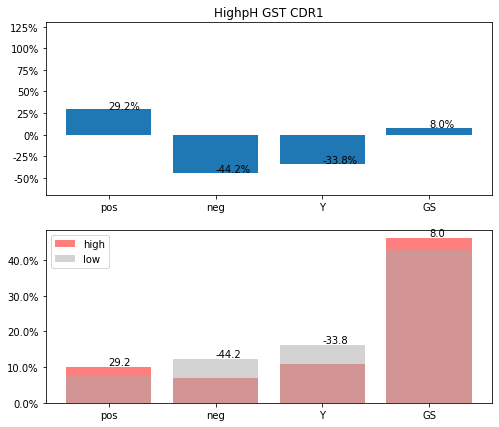

In [38]:
plt.figure(figsize=(8,7))
plt.subplot(211)
plt.title("HighpH GST CDR1")

high = High_CDR1_Unique_CDR_HighpH[[aa for aa in 'GASCDPNTEVQHMILKRFYW']].sum(0)/High_CDR1_Unique_CDR_HighpH['CDR1'].apply(lambda x:len(x)-4).sum()
low = Low_CDR1_Unique_CDR_HighpH[[aa for aa in 'GASCDPNTEVQHMILKRFYW']].sum(0)/Low_CDR1_Unique_CDR_HighpH['CDR1'].apply(lambda x:len(x)-4).sum()
low['pos'] = low[['K','R','H']].sum()
low['neg'] = low[['D','E']].sum()
low['Y'] = low[['Y']].sum()
low['GS'] =  low[['G','S']].sum()


high['pos'] = high[['K','R','H']].sum()
high['neg'] = high[['D','E']].sum()
high['Y'] = high[['Y']].sum()
high['GS'] =  high[['G','S']].sum()


selected_low = low.loc[['pos','neg','Y',"GS"]]
selected_aas_in_low = selected_low.index
selected_high = high.loc[selected_aas_in_low]

diff = ((selected_high-selected_low)/selected_low)
plt.bar(diff.index,diff.values)
plt.ylim((-0.7,1.3))
for aa in diff.index:
    plt.text(aa,diff.loc[aa]+0.01,"{}%".format(round(100*diff.loc[aa],1)))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#plt.savefig("Concentration_head_cdr3_percentage_change.svg",format='svg')


data = pd.DataFrame({"aa":selected_low.index,"high":selected_high.values,"low":selected_low.values})
data['diff'] = (data['high']-data['low'])/data['low']
#data.sort_values('diff',ascending=True,inplace=True)
#sns.barplot(x='aa',y='high',data=data,color='red',alpha=0.5,label='High')
#sns.barplot(x='aa',y='low',data=data,color='grey',alpha=0.5,label='Low')
plt.subplot(212)
plt.bar(data['aa'],data['high'],color='red',alpha=0.5,label='high')
plt.bar(data['aa'],data['low'],color='darkgrey',alpha=0.5,label='low')

for i,r in data.iterrows():
    plt.text(r['aa'],(r['high'] if r['high']>r['low'] else r['low'] )+0.005,round(r['diff']*100,1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
plt.savefig("GST_Figures/GST_CDR1_AA_group_Concentration(Unique CDR).svg",format='svg')

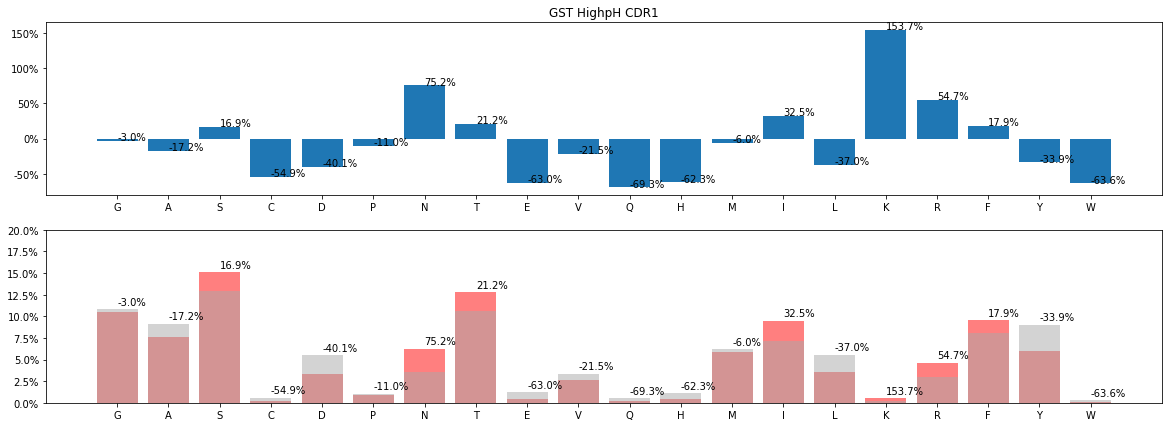

In [75]:

plt.figure(figsize=(20,7))
plt.subplot(211)

high = High_CDR1_Unique_CDR_HighpH[[aa for aa in 'GASCDPNTEVQHMILKRFYW']].sum(0)/High_CDR1_Unique_CDR_HighpH['CDR1'].apply(lambda x:len(x)).sum()
low = Low_CDR1_Unique_CDR_HighpH[[aa for aa in 'GASCDPNTEVQHMILKRFYW']].sum(0)/Low_CDR1_Unique_CDR_HighpH['CDR1'].apply(lambda x:len(x)).sum()

selected_low = low.loc[low.index.map(low>0)]
selected_aas_in_low = selected_low.index
selected_high = high.loc[selected_aas_in_low]

diff = ((selected_high-selected_low)/selected_low)
plt.bar(diff.index,diff.values)
for aa in diff.index:
    plt.text(aa,diff.loc[aa]+0.01,"{}%".format(round(100*diff.loc[aa],1)))
    
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
#plt.xticks(rotation=-45)
plt.title("GST HighpH CDR1")

data = pd.DataFrame({"aa":selected_low.index,"high":selected_high.values,"low":selected_low.values})
data['diff'] = (data['high']-data['low'])/data['low']
#data.sort_values('diff',ascending=True,inplace=True)
#sns.barplot(x='aa',y='high',data=data,color='red',alpha=0.5,label='High')
#sns.barplot(x='aa',y='low',data=data,color='grey',alpha=0.5,label='Low')
plt.subplot(212)
plt.bar(data['aa'],data['high'],color='red',alpha=0.5,label='high')
plt.bar(data['aa'],data['low'],color='darkgrey',alpha=0.5,label='low')

for i,r in data.iterrows():
    plt.text(r['aa'],(r['high'] if r['high']>r['low'] else r['low'] )+0.005,"{}%".format(round(r['diff']*100,1)))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
#plt.xticks(rotation=-45)
plt.ylim(ymax=0.2)

#plt.legend()
plt.savefig("GST_Figures/GST_AA_CDR1_Concentration(UniqueCDR).svg",format='svg')

In [71]:
def counts_2(data):
    aa_counts = (data[[aa for aa in 'GASCDPNTEVQHMILKRFYW']].sum(0)/data['CDR1'].apply(lambda x:len(x)).sum()).sort_values(ascending=False)
    AAs = aa_counts.index
    AAs = aa_counts.index
    AA_Counts = aa_counts.values
    
    return [AAs,AA_Counts]

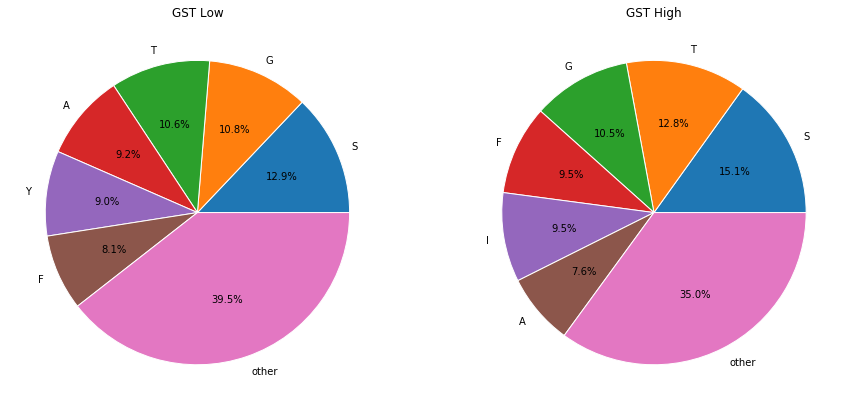

In [72]:
plt.figure(figsize=(15,8))
plt.subplot(121)
aa,aa_counts = counts_2(Low_CDR1_Unique_CDR_HighpH)

plt.pie(
    list(aa_counts[:6]) + [aa_counts[6:].sum()],
    labels =list(aa[:6]) + ['other'],
    radius=1,
    wedgeprops=dict(width=1, edgecolor='w'),
autopct= "%1.1f%%")
plt.title("GST Low")
plt.subplot(122)
aa,aa_counts = counts_2(High_CDR1_Unique_CDR_HighpH)

plt.pie(
    list(aa_counts[:6]) + [aa_counts[6:].sum()],
    labels =list(aa[:6]) + ['other'],
    radius=1,
    wedgeprops=dict(width=1, edgecolor='w'),
autopct= "%1.1f%%")
plt.title("GST High")
plt.savefig("GST_Figures/PieChart GST CDR1 AA percentage(Unique CDR).svg",format='svg')

## CDR2 Amino acid Composition

In [17]:
High_CDR2_Unique_CDR_HighpH = Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='2']
Low_CDR2_Unique_CDR_HighpH = Unique_CDR_HighpH[Unique_CDR_HighpH['HighpH']=='0']

In [18]:
for aa in 'GASPVTCILNDQKEMHFRYW':
    High_CDR2_Unique_CDR_HighpH[aa] = High_CDR2_Unique_CDR_HighpH['CDR2'].apply(lambda x: x.count(aa))
    Low_CDR2_Unique_CDR_HighpH[aa] = Low_CDR2_Unique_CDR_HighpH['CDR1'].apply(lambda x: x.count(aa))

c:\users\shi lab\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\shi lab\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


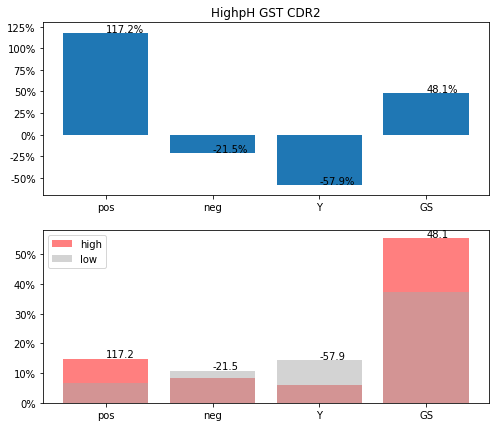

In [37]:
plt.figure(figsize=(8,7))
plt.subplot(211)
plt.title("HighpH GST CDR2")

high = High_CDR2_Unique_CDR_HighpH[[aa for aa in 'GASCDPNTEVQHMILKRFYW']].sum(0)/High_CDR2_Unique_CDR_HighpH['CDR2'].apply(lambda x:len(x)-4).sum()
low = Low_CDR2_Unique_CDR_HighpH[[aa for aa in 'GASCDPNTEVQHMILKRFYW']].sum(0)/Low_CDR2_Unique_CDR_HighpH['CDR2'].apply(lambda x:len(x)-4).sum()
low['pos'] = low[['K','R','H']].sum()
low['neg'] = low[['D','E']].sum()
low['Y'] = low[['Y']].sum()
low['GS'] =  low[['G','S']].sum()


high['pos'] = high[['K','R','H']].sum()
high['neg'] = high[['D','E']].sum()
high['Y'] = high[['Y']].sum()
high['GS'] =  high[['G','S']].sum()


selected_low = low.loc[['pos','neg','Y',"GS"]]
selected_aas_in_low = selected_low.index
selected_high = high.loc[selected_aas_in_low]

diff = ((selected_high-selected_low)/selected_low)
plt.bar(diff.index,diff.values)
#plt.yticks([-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1.0,1.2])
plt.ylim((-0.7,1.3))
for aa in diff.index:
    plt.text(aa,diff.loc[aa]+0.01,"{}%".format(round(100*diff.loc[aa],1)))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#plt.savefig("Concentration_head_cdr3_percentage_change.svg",format='svg')


data = pd.DataFrame({"aa":selected_low.index,"high":selected_high.values,"low":selected_low.values})
data['diff'] = (data['high']-data['low'])/data['low']
#data.sort_values('diff',ascending=True,inplace=True)
#sns.barplot(x='aa',y='high',data=data,color='red',alpha=0.5,label='High')
#sns.barplot(x='aa',y='low',data=data,color='grey',alpha=0.5,label='Low')
plt.subplot(212)
plt.bar(data['aa'],data['high'],color='red',alpha=0.5,label='high')
plt.bar(data['aa'],data['low'],color='darkgrey',alpha=0.5,label='low')

for i,r in data.iterrows():
    plt.text(r['aa'],(r['high'] if r['high']>r['low'] else r['low'] )+0.005,round(r['diff']*100,1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
plt.savefig("GST_Figures/GST_CDR2_AA_group_Concentration(Unique CDR).svg",format='svg')

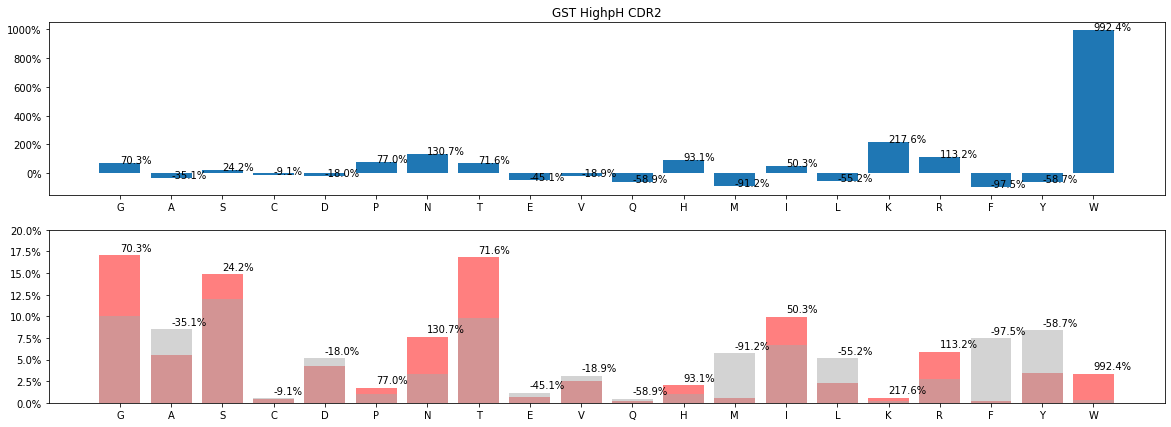

In [78]:

plt.figure(figsize=(20,7))
plt.subplot(211)

high = High_CDR2_Unique_CDR_HighpH[[aa for aa in 'GASCDPNTEVQHMILKRFYW']].sum(0)/High_CDR2_Unique_CDR_HighpH['CDR2'].apply(lambda x:len(x)).sum()
low = Low_CDR2_Unique_CDR_HighpH[[aa for aa in 'GASCDPNTEVQHMILKRFYW']].sum(0)/Low_CDR2_Unique_CDR_HighpH['CDR2'].apply(lambda x:len(x)).sum()

selected_low = low.loc[low.index.map(low>0)]
selected_aas_in_low = selected_low.index
selected_high = high.loc[selected_aas_in_low]

diff = ((selected_high-selected_low)/selected_low)
plt.bar(diff.index,diff.values)
for aa in diff.index:
    plt.text(aa,diff.loc[aa]+0.01,"{}%".format(round(100*diff.loc[aa],1)))
    
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
#plt.xticks(rotation=-45)
plt.title("GST HighpH CDR2")

data = pd.DataFrame({"aa":selected_low.index,"high":selected_high.values,"low":selected_low.values})
data['diff'] = (data['high']-data['low'])/data['low']
#data.sort_values('diff',ascending=True,inplace=True)
#sns.barplot(x='aa',y='high',data=data,color='red',alpha=0.5,label='High')
#sns.barplot(x='aa',y='low',data=data,color='grey',alpha=0.5,label='Low')
plt.subplot(212)
plt.bar(data['aa'],data['high'],color='red',alpha=0.5,label='high')
plt.bar(data['aa'],data['low'],color='darkgrey',alpha=0.5,label='low')

for i,r in data.iterrows():
    plt.text(r['aa'],(r['high'] if r['high']>r['low'] else r['low'] )+0.005,"{}%".format(round(r['diff']*100,1)))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
#plt.xticks(rotation=-45)
plt.ylim(ymax=0.2)

#plt.legend()
plt.savefig("GST_Figures/GST_AA_CDR2_Concentration(UniqueCDR).svg",format='svg')

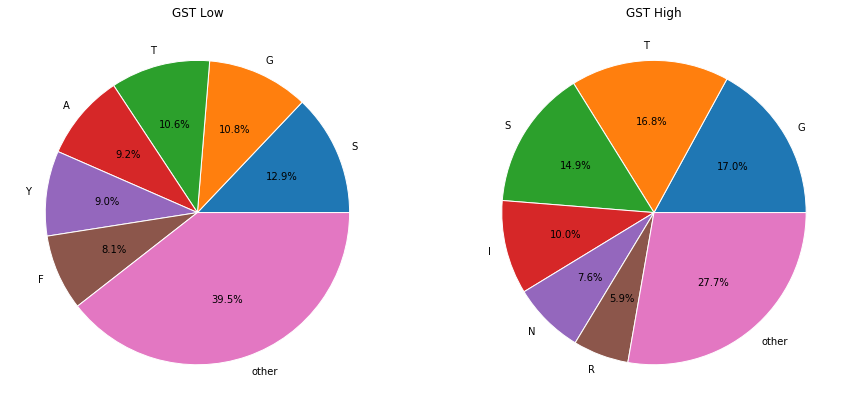

In [77]:
plt.figure(figsize=(15,8))
plt.subplot(121)
aa,aa_counts = counts_2(Low_CDR2_Unique_CDR_HighpH)

plt.pie(
    list(aa_counts[:6]) + [aa_counts[6:].sum()],
    labels =list(aa[:6]) + ['other'],
    radius=1,
    wedgeprops=dict(width=1, edgecolor='w'),
autopct= "%1.1f%%")
plt.title("GST Low")
plt.subplot(122)
aa,aa_counts = counts_2(High_CDR2_Unique_CDR_HighpH)

plt.pie(
    list(aa_counts[:6]) + [aa_counts[6:].sum()],
    labels =list(aa[:6]) + ['other'],
    radius=1,
    wedgeprops=dict(width=1, edgecolor='w'),
autopct= "%1.1f%%")
plt.title("GST High")
plt.savefig("GST_Figures/PieChart GST CDR2 AA percentage(Unique CDR).svg",format='svg')

## Unique HighpH CDR3 Feature

Get rid of ambiguous CDR3 assignments; One CDR3 must only have 1 class

In [20]:
Unique_CDR3_HighpH = HighpH.groupby("CDR3").filter(lambda x:x['HighpH'].unique().shape[0]<2).drop_duplicates("CDR3")

In [118]:
Unique_CDR3_HighpH.to_csv("GST_Unique_CDR3_HighpH.csv")

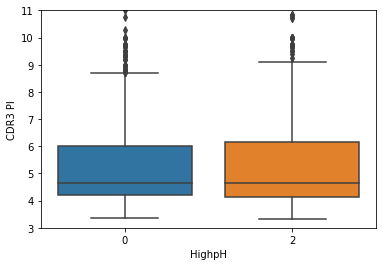

In [13]:
sns.boxplot(x = 'HighpH',y='CDR3 PI',data = Unique_CDR3_HighpH[(Unique_CDR3_HighpH['HighpH']=='0')|(Unique_CDR3_HighpH['HighpH']=='2')])
plt.ylim((3,11))
plt.savefig("GST_CDR3_PI.svg",format='svg')

### CDR3 Head Region

In [21]:
Unique_CDR3_HighpH['Head_CDR3'] = Unique_CDR3_HighpH['CDR3'].apply(lambda x: x[:-4])
Unique_CDR3_HighpH['Head_CDR3 PI'] = Unique_CDR3_HighpH['Head_CDR3'].apply(lambda x: ProteinAnalysis(x).isoelectric_point() if x!="" else 0)
for aa in 'GASPVTCILNDQKEMHFRYW':
    Unique_CDR3_HighpH['head_'+aa] = Unique_CDR3_HighpH['Head_CDR3'].apply(lambda x: x.count(aa))
for aa in 'GASPVTCILNDQKEMHFRYW':
    Unique_CDR3_HighpH[aa] = Unique_CDR3_HighpH['CDR3'].apply(lambda x: x.count(aa))
for aa in 'GASPVTCILNDQKEMHFRYW':
    Unique_CDR3_HighpH['head_'+aa+"_dens"] = Unique_CDR3_HighpH['Head_CDR3'].apply(lambda x: x.count(aa)/len(x) if x!="" else 0)
for aa in 'GASPVTCILNDQKEMHFRYW':
    Unique_CDR3_HighpH[aa+"_dens"] = Unique_CDR3_HighpH['CDR3'].apply(lambda x: x.count(aa)/len(x) )

Absolute Number change

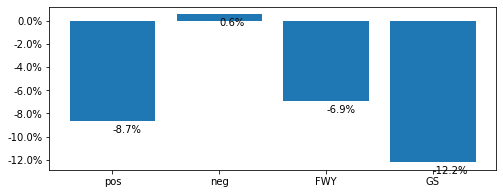

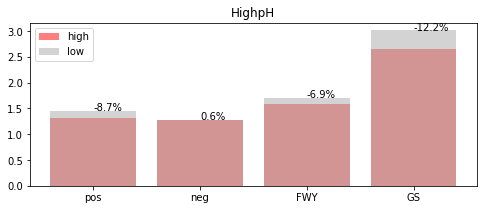

In [22]:

plt.figure(figsize=(8,3))
high = Unique_CDR3_HighpH[Unique_CDR3_HighpH['HighpH']=='2'][["head_"+aa for aa in 'YDSLGRAVTPEINFHCQWMK']].mean(0)
low = Unique_CDR3_HighpH[Unique_CDR3_HighpH['HighpH']=='0'][["head_"+aa for aa in 'YDSLGRAVTPEINFHCQWMK']].mean(0)
low['pos'] = low[['head_K','head_R','head_H']].sum()
low['neg'] = low[['head_D','head_E']].sum()
low['FWY'] = low[['head_F','head_W','head_Y']].sum()
low['GS'] =  low[['head_G','head_S']].sum()


high['pos'] = high[['head_K','head_R','head_H']].sum()
high['neg'] = high[['head_D','head_E']].sum()
high['FWY'] = high[['head_F','head_W','head_Y']].sum()
high['GS'] =  high[['head_G','head_S']].sum()


selected_low = low.loc[['pos','neg','FWY',"GS"]]
selected_aas_in_low = selected_low.index
selected_high = high.loc[selected_aas_in_low]

diff = ((selected_high-selected_low)/selected_low)
plt.bar(diff.index,diff.values)

for aa in diff.index:
    plt.text(aa,diff.loc[aa]-0.01,"{}%".format(round(100*diff.loc[aa],1)))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#plt.savefig("Concentration_head_cdr3_percentage_change.svg",format='svg')


data = pd.DataFrame({"aa":selected_low.index,"high":selected_high.values,"low":selected_low.values})
data['diff'] = (data['high']-data['low'])/data['low']
#data.sort_values('diff',ascending=True,inplace=True)
#sns.barplot(x='aa',y='high',data=data,color='red',alpha=0.5,label='High')
#sns.barplot(x='aa',y='low',data=data,color='grey',alpha=0.5,label='Low')
plt.figure(figsize=(8,3))
plt.bar(data['aa'],data['high'],color='red',alpha=0.5,label='high')
plt.bar(data['aa'],data['low'],color='darkgrey',alpha=0.5,label='low')

for i,r in data.iterrows():
    plt.text(r['aa'],(r['high'] if r['high']>r['low'] else r['low'] )+0.005,"{}%".format(round(r['diff']*100,1)))
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("HighpH")
plt.legend()

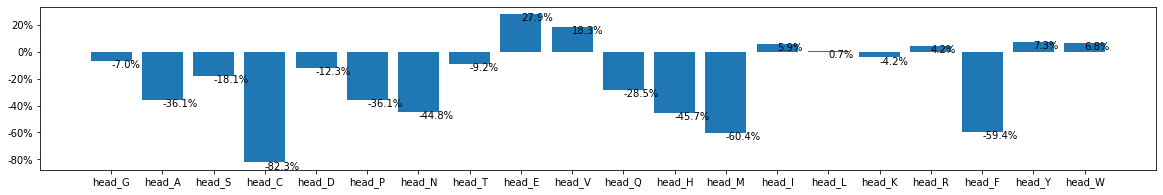

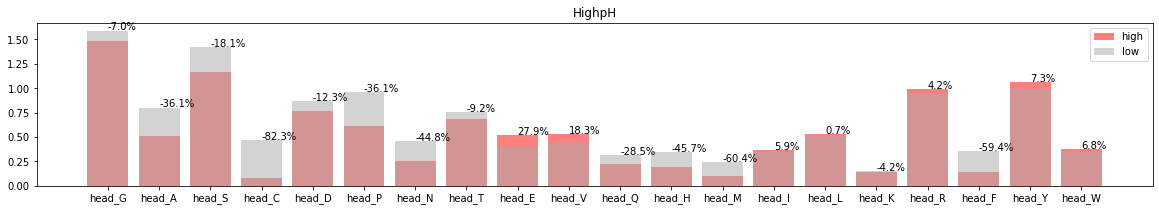

In [16]:

plt.figure(figsize=(20,3))

high = Unique_CDR3_HighpH[Unique_CDR3_HighpH['HighpH']=='2'][["head_"+aa for aa in 'GASCDPNTEVQHMILKRFYW']].mean(0)
low = Unique_CDR3_HighpH[Unique_CDR3_HighpH['HighpH']=='0'][["head_"+aa for aa in 'GASCDPNTEVQHMILKRFYW']].mean(0)
selected_low = low.loc[low.index.map(low>0)]
selected_aas_in_low = selected_low.index
selected_high = high.loc[selected_aas_in_low]

diff = ((selected_high-selected_low)/selected_low)
plt.bar(diff.index,diff.values)
for aa in diff.index:
    plt.text(aa,diff.loc[aa]-0.05,"{}%".format(round(100*diff.loc[aa],1)))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
#plt.savefig("ALL_Concentration_head_cdr3_percentage_change.svg",format='svg')


data = pd.DataFrame({"aa":selected_low.index,"high":selected_high.values,"low":selected_low.values})
data['diff'] = (data['high']-data['low'])/data['low']
#data.sort_values('diff',ascending=True,inplace=True)
#sns.barplot(x='aa',y='high',data=data,color='red',alpha=0.5,label='High')
#sns.barplot(x='aa',y='low',data=data,color='grey',alpha=0.5,label='Low')
plt.figure(figsize=(20,3))
plt.bar(data['aa'],data['high'],color='red',alpha=0.5,label='high')
plt.bar(data['aa'],data['low'],color='darkgrey',alpha=0.5,label='low')

for i,r in data.iterrows():
    plt.text(r['aa'],(r['high'] if r['high']>r['low'] else r['low'] )+0.005,"{}%".format(round(r['diff']*100,1)))
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title("HighpH")
plt.legend()

## Amino acid concentration change

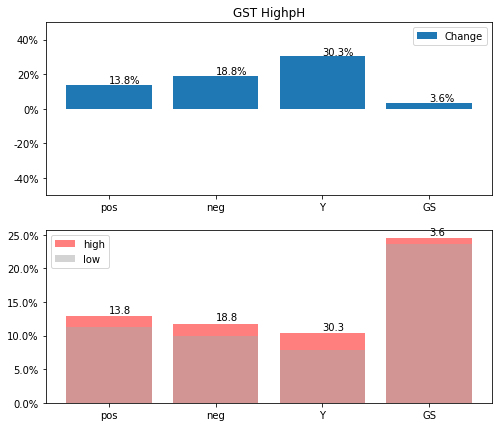

In [24]:

plt.figure(figsize=(8,7))
plt.subplot(211)
high = Unique_CDR3_HighpH[Unique_CDR3_HighpH['HighpH']=='2'][["head_"+aa+"_dens" for aa in 'YDSLGRAVTPEINFHCQWMK']].mean(0)
low = Unique_CDR3_HighpH[Unique_CDR3_HighpH['HighpH']=='0'][["head_"+aa+"_dens" for aa in 'YDSLGRAVTPEINFHCQWMK']].mean(0)
low['pos'] = low[['head_K_dens','head_R_dens','head_H_dens']].sum()
low['neg'] = low[['head_D_dens','head_E_dens']].sum()
low['Y'] = low[['head_Y_dens']].sum()
low['GS'] =  low[['head_G_dens','head_S_dens']].sum()


high['pos'] = high[['head_K_dens','head_R_dens','head_H_dens']].sum()
high['neg'] = high[['head_D_dens','head_E_dens']].sum()
high['Y'] = high[['head_Y_dens']].sum()
high['GS'] =  high[['head_G_dens','head_S_dens']].sum()


selected_low = low.loc[['pos','neg','Y',"GS"]]
selected_aas_in_low = selected_low.index
selected_high = high.loc[selected_aas_in_low]

diff = ((selected_high-selected_low)/selected_low)
plt.bar(diff.index,diff.values,label="Change")

for aa in diff.index:
    plt.text(aa,diff.loc[aa]+0.01,"{}%".format(round(100*diff.loc[aa],1)))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
plt.ylim(ymax=0.5,ymin=-0.5)
plt.title("GST HighpH")
#plt.savefig("Concentration_head_cdr3_percentage_change.svg",format='svg')


data = pd.DataFrame({"aa":selected_low.index,"high":selected_high.values,"low":selected_low.values})
data['diff'] = (data['high']-data['low'])/data['low']
#data.sort_values('diff',ascending=True,inplace=True)
#sns.barplot(x='aa',y='high',data=data,color='red',alpha=0.5,label='High')
#sns.barplot(x='aa',y='low',data=data,color='grey',alpha=0.5,label='Low')
plt.subplot(212)

plt.bar(data['aa'],data['high'],color='red',alpha=0.5,label='high')
plt.bar(data['aa'],data['low'],color='darkgrey',alpha=0.5,label='low')

for i,r in data.iterrows():
    plt.text(r['aa'],(r['high'] if r['high']>r['low'] else r['low'] )+0.005,round(r['diff']*100,1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
#plt.savefig("GST_Figures/AA_group_Concentration.svg",format='svg')

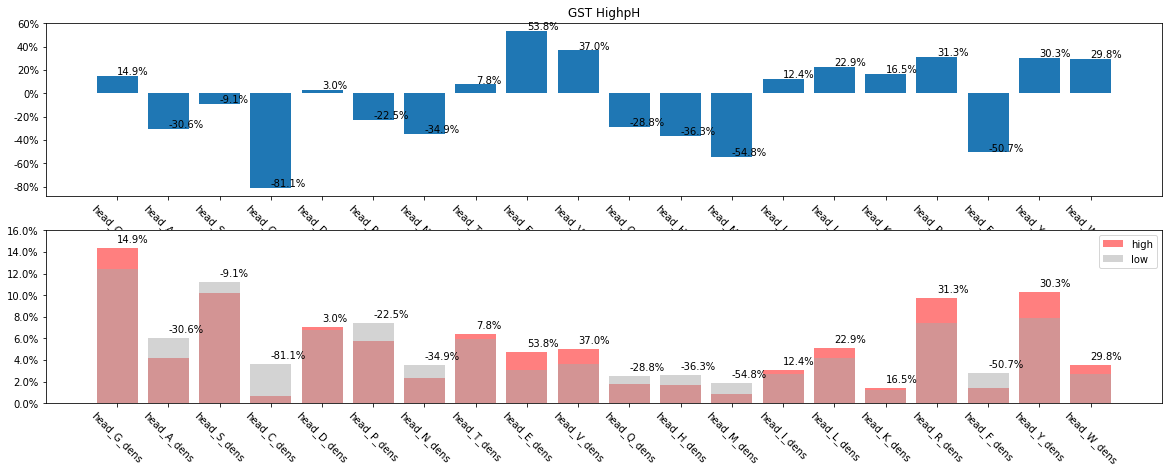

In [18]:

plt.figure(figsize=(20,7))
plt.subplot(211)
high = Unique_CDR3_HighpH[Unique_CDR3_HighpH['HighpH']=='2'][["head_"+aa+"_dens" for aa in 'GASCDPNTEVQHMILKRFYW']].mean(0)
low = Unique_CDR3_HighpH[Unique_CDR3_HighpH['HighpH']=='0'][["head_"+aa+"_dens" for aa in 'GASCDPNTEVQHMILKRFYW']].mean(0)
selected_low = low.loc[low.index.map(low>0)]
selected_aas_in_low = selected_low.index
selected_high = high.loc[selected_aas_in_low]

diff = ((selected_high-selected_low)/selected_low)
plt.bar(diff.index,diff.values)
for aa in diff.index:
    plt.text(aa,diff.loc[aa]+0.01,"{}%".format(round(100*diff.loc[aa],1)))
    
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(rotation=-45)
plt.title("GST HighpH")

data = pd.DataFrame({"aa":selected_low.index,"high":selected_high.values,"low":selected_low.values})
data['diff'] = (data['high']-data['low'])/data['low']
#data.sort_values('diff',ascending=True,inplace=True)
#sns.barplot(x='aa',y='high',data=data,color='red',alpha=0.5,label='High')
#sns.barplot(x='aa',y='low',data=data,color='grey',alpha=0.5,label='Low')
plt.subplot(212)
plt.bar(data['aa'],data['high'],color='red',alpha=0.5,label='high')
plt.bar(data['aa'],data['low'],color='darkgrey',alpha=0.5,label='low')

for i,r in data.iterrows():
    plt.text(r['aa'],(r['high'] if r['high']>r['low'] else r['low'] )+0.005,"{}%".format(round(r['diff']*100,1)))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(rotation=-45)
plt.ylim(ymax=0.16)

plt.legend()
plt.savefig("GST_Figures/AA_Concentration.svg",format='svg')

In [19]:
def counts(data):
    aa_counts = data[["head_"+aa+"_dens" for aa in 'YDSLGRAVTPEINFHCQWMK']].mean(0).sort_values(ascending=False)
    AAs = aa_counts.index
    AA_Counts = aa_counts.values
    
    return [AAs,AA_Counts]

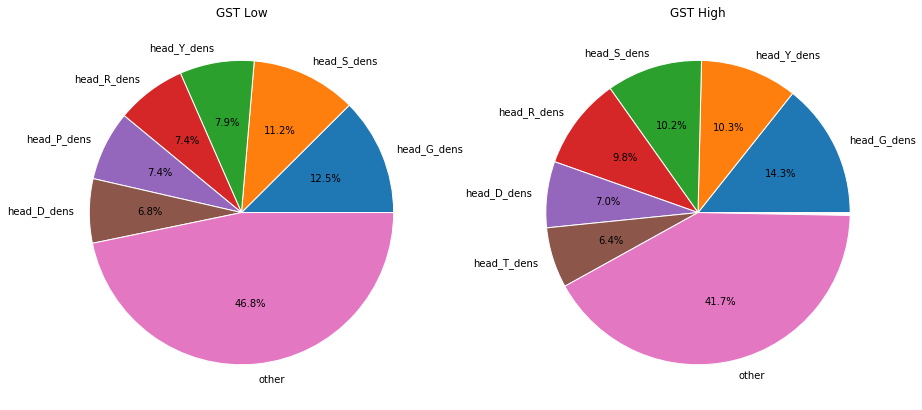

In [20]:
plt.figure(figsize=(15,8))
plt.subplot(121)
aa,aa_counts = counts(Unique_CDR3_HighpH[Unique_CDR3_HighpH['HighpH']=='0'])

plt.pie(
    list(aa_counts[:6]) + [aa_counts[6:].sum()],
    labels =list(aa[:6]) + ['other'],
    radius=1,
    wedgeprops=dict(width=1, edgecolor='w'),
autopct= "%1.1f%%")
plt.title("GST Low")
plt.subplot(122)
aa,aa_counts = counts(Unique_CDR3_HighpH[Unique_CDR3_HighpH['HighpH']=='2'])

plt.pie(
    list(aa_counts[:6]) + [aa_counts[6:].sum()],
    labels =list(aa[:6]) + ['other'],
    radius=1,
    wedgeprops=dict(width=1, edgecolor='w'),
autopct= "%1.1f%%")
plt.title("GST High")
plt.savefig("PieChart GST AA percentage.svg",format='svg')

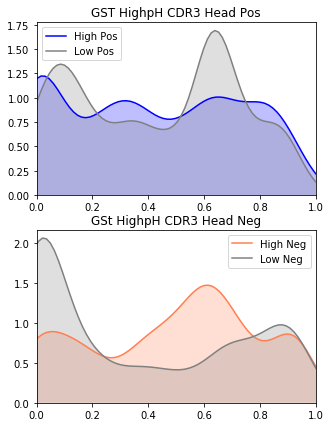

In [119]:
high_p=[]
high_n=[]

for cdr3 in Unique_CDR3_HighpH[Unique_CDR3_HighpH['HighpH']=='2']['CDR3']:
    if not ("R" in cdr3 or "K" in cdr3):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='K' or res =='R':
                pos.append(i/(len(cdr3)-4))

    high_p += pos
    
for cdr3 in Unique_CDR3_HighpH[Unique_CDR3_HighpH['HighpH']=='2']['CDR3']:
    if not ("D" in cdr3 or "E" in cdr3):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='D' or res =='E':
                pos.append(i/(len(cdr3)-4))

    high_n += pos
low_p=[]
low_n=[]

for cdr3 in Unique_CDR3_HighpH[Unique_CDR3_HighpH['HighpH']=='0']['CDR3']:
    if not ("R" in cdr3 or "K" in cdr3 ):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='K' or res =='R':
                pos.append(i/(len(cdr3)-4))

    low_p += pos
    
for cdr3 in Unique_CDR3_HighpH[Unique_CDR3_HighpH['HighpH']=='0']['CDR3']:
    if not ("D" in cdr3 or "E" in cdr3):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='D' or res =='E':
                pos.append(i/(len(cdr3)-4))

    low_n += pos
plt.figure(figsize=(5,7))
plt.subplot(211)
plt.title("GST HighpH CDR3 Head Pos")
sns.distplot(high_p,hist=False,label='High Pos',kde_kws={'shade':True},color='blue')
sns.distplot(low_p,hist=False,label='Low Pos',kde_kws={'shade':True},color='grey')

plt.xlim((0,1))
plt.subplot(212)
plt.title("GSt HighpH CDR3 Head Neg")
sns.distplot(high_n,hist=False,label='High Neg',kde_kws={'shade':True},color='coral')
sns.distplot(low_n,hist=False,label='Low Neg',kde_kws={'shade':True},color='grey')
plt.xlim((0,1))
plt.legend()
#plt.savefig("GST_Figures\GST_Charge_CDR3_head_position.svg",format='svg')

In [219]:
def draw_position_plot(data,bins,label,color):
    h,x = np.histogram(data, bins=np.arange(0,20,1)/20,weights=np.ones(len(data)) / len(data))
    #x = [(x[i]+x[i+1])/2 for i in range(len(x)-1)]
    x = x[:-1]
    plt.plot(x,h,linestyle='dashed',label='real_{}'.format(label),color=color)
    #plt.fill_between(x,0,h,alpha=0.5,label='smooth_{}'.format(label),color=color)
    #h = pd.Series(data).rolling(window=bins).mean()
    #h = [np.mean(data[i-1:i+2]) for i in range(len(data))]
    h = gaussian_filter1d(h,1)
    plt.ylim(ymax=0.25)
    #ax.plot(x,h,label=label,c=color)
    plt.fill_between(x,0,h,alpha=0.5,label='smooth_{}'.format(label),color=color,alpha=0.5)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
    plt.legend()



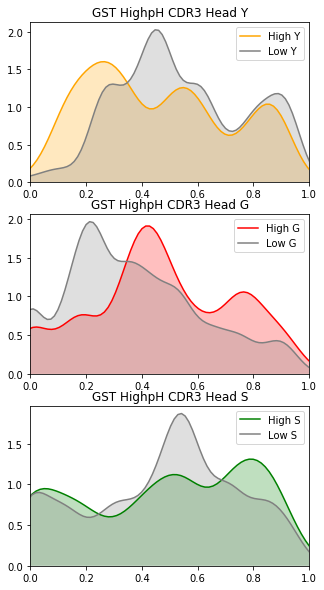

In [225]:
high_G=[]
high_Y=[]
high_S=[]
for cdr3 in Unique_CDR3_HighpH[Unique_CDR3_HighpH['HighpH']=='2']['CDR3']:
    if not ("Y" in cdr3):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='Y':
                pos.append(i/(len(cdr3)-4))

    high_Y += pos
for cdr3 in Unique_CDR3_HighpH[Unique_CDR3_HighpH['HighpH']=='2']['CDR3']:
    if not ("G" in cdr3):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='G':
                pos.append(i/(len(cdr3)-4))

    high_G += pos
for cdr3 in Unique_CDR3_HighpH[Unique_CDR3_HighpH['HighpH']=='2']['CDR3']:
    if not ("S" in cdr3):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='S':
                pos.append(i/(len(cdr3)-4))

    high_S += pos

low_G=[]
low_Y=[]
low_S=[]

for cdr3 in Unique_CDR3_HighpH[Unique_CDR3_HighpH['HighpH']=='0']['CDR3']:
    if not ("Y" in cdr3):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='Y':
                pos.append(i/(len(cdr3)-4))

    low_Y += pos
for cdr3 in Unique_CDR3_HighpH[Unique_CDR3_HighpH['HighpH']=='0']['CDR3']:
    if not ("G" in cdr3):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='G':
                pos.append(i/(len(cdr3)-4))

    low_G += pos
for cdr3 in Unique_CDR3_HighpH[Unique_CDR3_HighpH['HighpH']=='0']['CDR3']:
    if not ("S" in cdr3):
        continue
    pos = []
    for i in range(len(cdr3)-4):
            res = cdr3[i]
            if res =='S':
                pos.append(i/(len(cdr3)-4))

    low_S += pos

plt.figure(figsize=(5,10))
plt.subplot(311)
plt.title("GST HighpH CDR3 Head Y")

sns.distplot(high_Y,hist=False,label='High Y',kde_kws={'shade':True},color='orange')
sns.distplot(low_Y,hist=False,label='Low Y',kde_kws={'shade':True},color='grey')

plt.xlim((0,1))
plt.subplot(312)
plt.title("GST HighpH CDR3 Head G")
sns.distplot(high_G,hist=False,label='High G',kde_kws={'shade':True},color='red')
sns.distplot(low_G,hist=False,label='Low G',kde_kws={'shade':True},color='grey')

plt.xlim((0,1))
plt.legend()
#plt.savefig("HSA_Figures\HSA_YGS_CDR3_head_position.svg",format='svg')
plt.subplot(313)
plt.title("GST HighpH CDR3 Head S")

sns.distplot(high_S,hist=False,label='High S',kde_kws={'shade':True},color='green')
sns.distplot(low_S,hist=False,label='Low S',kde_kws={'shade':True},color='grey')
plt.xlim((0,1))
plt.legend()
#plt.savefig("GST_Figures\GST_YGS_CDR3_head_position.svg",format='svg')

## Unique HighpH CDR1 Feature

In [21]:
def counts_2(data):
    aa_counts = data[[aa+"_dens" for aa in 'YDSLGRAVTPEINFHCQWMK']].mean(0).sort_values(ascending=False)
    AAs = aa_counts.index
    AA_Counts = aa_counts.values
    
    return [AAs,AA_Counts]

In [22]:
Unique_CDR1_HighpH = HighpH.groupby("CDR1").filter(lambda x:x['HighpH'].unique().shape[0]<2).drop_duplicates("CDR1")

### CDR1 Region

In [23]:

for aa in 'GASPVTCILNDQKEMHFRYW':
    Unique_CDR1_HighpH[aa] = Unique_CDR1_HighpH['CDR1'].apply(lambda x: x.count(aa))

for aa in 'GASPVTCILNDQKEMHFRYW':
    Unique_CDR1_HighpH[aa+"_dens"] = Unique_CDR1_HighpH['CDR1'].apply(lambda x: x.count(aa)/len(x) )

In [102]:
Unique_CDR1_HighpH.to_csv("GST_Unique_CDR1_HighpH.csv")

Amino acid concentration change

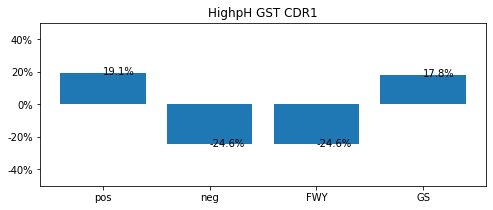

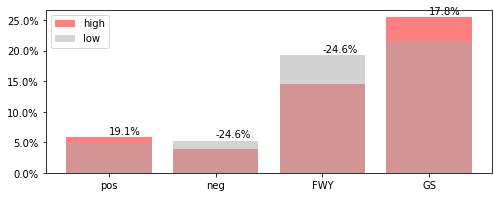

In [87]:

plt.figure(figsize=(8,3))
high = Unique_CDR1_HighpH[Unique_CDR1_HighpH['HighpH']=='2'][[aa+"_dens" for aa in 'YDSLGRAVTPEINFHCQWMK']].mean(0)
low = Unique_CDR1_HighpH[Unique_CDR1_HighpH['HighpH']=='0'][[aa+"_dens" for aa in 'YDSLGRAVTPEINFHCQWMK']].mean(0)
low['pos'] = low[['K_dens','R_dens','H_dens']].sum()
low['neg'] = low[['D_dens','E_dens']].sum()
low['FWY'] = low[['F_dens','W_dens','Y_dens']].sum()
low['GS'] =  low[['G_dens','S_dens']].sum()


high['pos'] = high[['K_dens','R_dens','H_dens']].sum()
high['neg'] = high[['D_dens','E_dens']].sum()
high['FWY'] = high[['F_dens','W_dens','Y_dens']].sum()
high['GS'] =  high[['G_dens','S_dens']].sum()



selected_low = low.loc[['pos','neg','FWY',"GS"]]
selected_aas_in_low = selected_low.index
selected_high = high.loc[selected_aas_in_low]

diff = ((selected_high-selected_low)/selected_low)
plt.bar(diff.index,diff.values)
plt.ylim((-0.5,0.5))
plt.title("HighpH GST CDR1")

for aa in diff.index:
    plt.text(aa,diff.loc[aa]-0.01,"{}%".format(round(100*diff.loc[aa],1)))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#plt.savefig("Concentration_head_cdr3_percentage_change.svg",format='svg')


data = pd.DataFrame({"aa":selected_low.index,"high":selected_high.values,"low":selected_low.values})
data['diff'] = (data['high']-data['low'])/data['low']
#data.sort_values('diff',ascending=True,inplace=True)
#sns.barplot(x='aa',y='high',data=data,color='red',alpha=0.5,label='High')
#sns.barplot(x='aa',y='low',data=data,color='grey',alpha=0.5,label='Low')
plt.figure(figsize=(8,3))
plt.bar(data['aa'],data['high'],color='red',alpha=0.5,label='high')
plt.bar(data['aa'],data['low'],color='darkgrey',alpha=0.5,label='low')

for i,r in data.iterrows():
    plt.text(r['aa'],(r['high'] if r['high']>r['low'] else r['low'] )+0.005,"{}%".format(round(r['diff']*100,1)))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
plt.savefig("GST_Figures/AA_group_CDR1_Concentration.svg",format='svg')

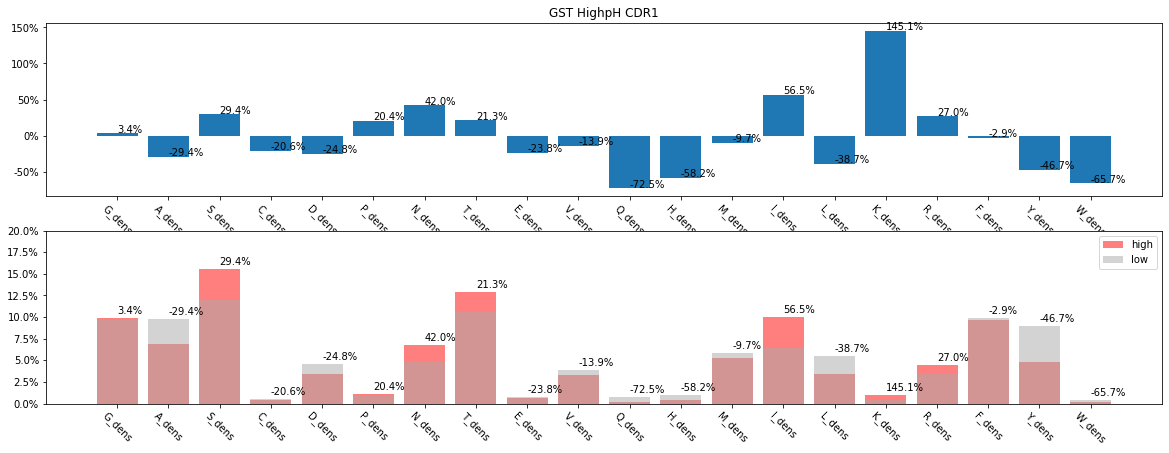

In [104]:

plt.figure(figsize=(20,7))
plt.subplot(211)
high = Unique_CDR1_HighpH[Unique_CDR1_HighpH['HighpH']=='2'][[aa+"_dens" for aa in 'GASCDPNTEVQHMILKRFYW']].mean(0)
low = Unique_CDR1_HighpH[Unique_CDR1_HighpH['HighpH']=='0'][[aa+"_dens" for aa in 'GASCDPNTEVQHMILKRFYW']].mean(0)
selected_low = low.loc[low.index.map(low>0)]
selected_aas_in_low = selected_low.index
selected_high = high.loc[selected_aas_in_low]

diff = ((selected_high-selected_low)/selected_low)
plt.bar(diff.index,diff.values)
for aa in diff.index:
    plt.text(aa,diff.loc[aa]+0.01,"{}%".format(round(100*diff.loc[aa],1)))
    
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(rotation=-45)
plt.title("GST HighpH CDR1")

data = pd.DataFrame({"aa":selected_low.index,"high":selected_high.values,"low":selected_low.values})
data['diff'] = (data['high']-data['low'])/data['low']
#data.sort_values('diff',ascending=True,inplace=True)
#sns.barplot(x='aa',y='high',data=data,color='red',alpha=0.5,label='High')
#sns.barplot(x='aa',y='low',data=data,color='grey',alpha=0.5,label='Low')
plt.subplot(212)
plt.bar(data['aa'],data['high'],color='red',alpha=0.5,label='high')
plt.bar(data['aa'],data['low'],color='darkgrey',alpha=0.5,label='low')

for i,r in data.iterrows():
    plt.text(r['aa'],(r['high'] if r['high']>r['low'] else r['low'] )+0.005,"{}%".format(round(r['diff']*100,1)))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(rotation=-45)
plt.ylim(ymax=0.2)

plt.legend()
plt.savefig("GST_Figures/AA_CDR1_Concentration.svg",format='svg')

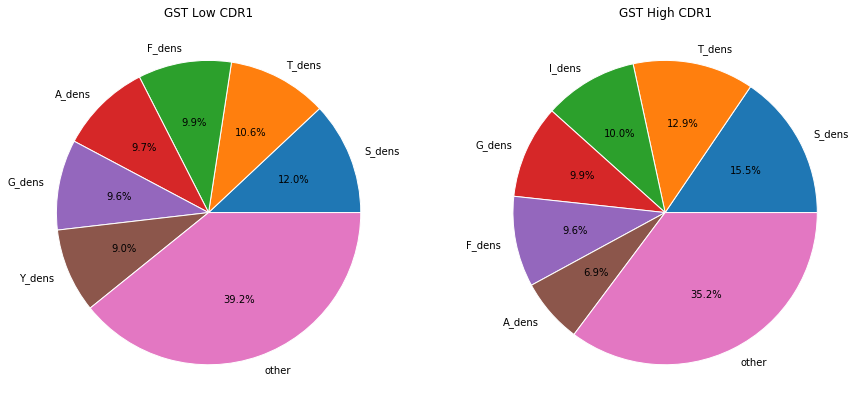

In [28]:
plt.figure(figsize=(15,8))
plt.subplot(121)
aa,aa_counts = counts_2(Unique_CDR1_HighpH[Unique_CDR1_HighpH['HighpH']=='0'])

plt.pie(
    list(aa_counts[:6]) + [aa_counts[6:].sum()],
    labels =list(aa[:6]) + ['other'],
    radius=1,
    wedgeprops=dict(width=1, edgecolor='w'),
autopct= "%1.1f%%")
plt.title("GST Low CDR1")
plt.subplot(122)
aa,aa_counts = counts_2(Unique_CDR1_HighpH[Unique_CDR1_HighpH['HighpH']=='2'])

plt.pie(
    list(aa_counts[:6]) + [aa_counts[6:].sum()],
    labels =list(aa[:6]) + ['other'],
    radius=1,
    wedgeprops=dict(width=1, edgecolor='w'),
autopct= "%1.1f%%")
plt.title("GST High CDR1")
plt.savefig("GST_Figures\PieChart GST CDR1 AA percentage.svg",format='svg')

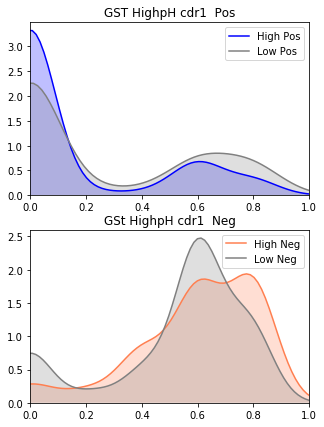

In [116]:


high_p=[]
high_n=[]

for cdr1 in Unique_CDR1_HighpH[Unique_CDR1_HighpH['HighpH']=='2']['CDR1']:
    if not ("R" in cdr1 or "K" in cdr1):
        continue
    pos = []
    for i in range(len(cdr1)-4):
            res = cdr1[i]
            if res =='K' or res =='R':
                pos.append(i/(len(cdr1)-4))

    high_p += pos
    
for cdr1 in Unique_CDR1_HighpH[Unique_CDR1_HighpH['HighpH']=='2']['CDR1']:
    if not ("D" in cdr1 or "E" in cdr1):
        continue
    pos = []
    for i in range(len(cdr1)-4):
            res = cdr1[i]
            if res =='D' or res =='E':
                pos.append(i/(len(cdr1)-4))

    high_n += pos
low_p=[]
low_n=[]

for cdr1 in Unique_CDR1_HighpH[Unique_CDR1_HighpH['HighpH']=='0']['CDR1']:
    if not ("R" in cdr1 or "K" in cdr1 ):
        continue
    pos = []
    for i in range(len(cdr1)-4):
            res = cdr1[i]
            if res =='K' or res =='R':
                pos.append(i/(len(cdr1)-4))

    low_p += pos
    
for cdr1 in Unique_CDR1_HighpH[Unique_CDR1_HighpH['HighpH']=='0']['CDR1']:
    if not ("D" in cdr1 or "E" in cdr1):
        continue
    pos = []
    for i in range(len(cdr1)-4):
            res = cdr1[i]
            if res =='D' or res =='E':
                pos.append(i/(len(cdr1)-4))

    low_n += pos
plt.figure(figsize=(5,7))
plt.subplot(211)
plt.title("GST HighpH cdr1  Pos")
sns.distplot(high_p,hist=False,label='High Pos',kde_kws={'shade':True},color='blue')
sns.distplot(low_p,hist=False,label='Low Pos',kde_kws={'shade':True},color='grey')

plt.xlim((0,1))
plt.subplot(212)
plt.title("GSt HighpH cdr1  Neg")
sns.distplot(high_n,hist=False,label='High Neg',kde_kws={'shade':True},color='coral')
sns.distplot(low_n,hist=False,label='Low Neg',kde_kws={'shade':True},color='grey')
plt.xlim((0,1))
plt.legend()
plt.savefig("GST_Figures\GST_Charge_cdr1_position.svg",format='svg')

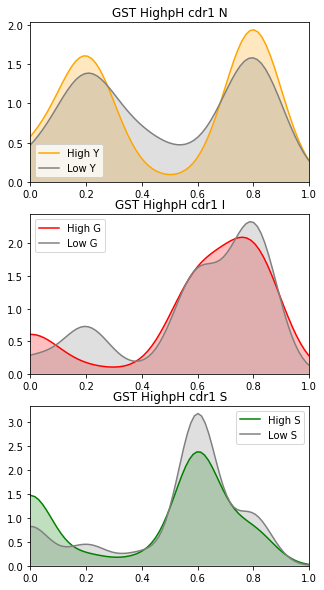

In [236]:
high_N=[]
high_I=[]
high_S=[]
for cdr1 in Unique_CDR1_HighpH[Unique_CDR1_HighpH['HighpH']=='2']['CDR1']:
    if not ("N" in cdr1):
        continue
    pos = []
    for i in range(len(cdr1)-4):
            res = cdr1[i]
            if res =='N':
                pos.append(i/(len(cdr1)-4))

    high_N += pos
for cdr1 in Unique_CDR1_HighpH[Unique_CDR1_HighpH['HighpH']=='2']['CDR1']:
    if not ("I" in cdr1):
        continue
    pos = []
    for i in range(len(cdr1)-4):
            res = cdr1[i]
            if res =='I':
                pos.append(i/(len(cdr1)-4))

    high_I += pos
for cdr1 in Unique_CDR1_HighpH[Unique_CDR1_HighpH['HighpH']=='2']['CDR1']:
    if not ("S" in cdr1):
        continue
    pos = []
    for i in range(len(cdr1)-4):
            res = cdr1[i]
            if res =='S':
                pos.append(i/(len(cdr1)-4))

    high_S += pos

low_N=[]
low_I=[]
low_S=[]

for cdr1 in Unique_CDR1_HighpH[Unique_CDR1_HighpH['HighpH']=='0']['CDR1']:
    if not ("N" in cdr1):
        continue
    pos = []
    for i in range(len(cdr1)-4):
            res = cdr1[i]
            if res =='N':
                pos.append(i/(len(cdr1)-4))

    low_N += pos
for cdr1 in Unique_CDR1_HighpH[Unique_CDR1_HighpH['HighpH']=='0']['CDR1']:
    if not ("I" in cdr1):
        continue
    pos = []
    for i in range(len(cdr1)-4):
            res = cdr1[i]
            if res =='I':
                pos.append(i/(len(cdr1)-4))

    low_I += pos
for cdr1 in Unique_CDR1_HighpH[Unique_CDR1_HighpH['HighpH']=='0']['CDR1']:
    if not ("S" in cdr1):
        continue
    pos = []
    for i in range(len(cdr1)-4):
            res = cdr1[i]
            if res =='S':
                pos.append(i/(len(cdr1)-4))

    low_S += pos

plt.figure(figsize=(5,10))
plt.subplot(311)
plt.title("GST HighpH cdr1 N")

sns.distplot(high_I,hist=False,label='High Y',kde_kws={'shade':True},color='orange')
sns.distplot(low_I,hist=False,label='Low Y',kde_kws={'shade':True},color='grey')

plt.xlim((0,1))
plt.subplot(312)
plt.title("GST HighpH cdr1 I")
sns.distplot(high_N,hist=False,label='High G',kde_kws={'shade':True},color='red')
sns.distplot(low_N,hist=False,label='Low G',kde_kws={'shade':True},color='grey')

plt.xlim((0,1))
plt.legend()
#plt.savefig("HSA_Figures\HSA_YGS_cdr1_head_position.svg",format='svg')
plt.subplot(313)
plt.title("GST HighpH cdr1 S")

sns.distplot(high_S,hist=False,label='High S',kde_kws={'shade':True},color='green')
sns.distplot(low_S,hist=False,label='Low S',kde_kws={'shade':True},color='grey')
plt.xlim((0,1))
plt.legend()
plt.savefig("GST_Figures\GST_NIS_CDR1_position.svg",format='svg')

## Unique HighpH CDR2 Feature

In [29]:
Unique_CDR2_HighpH = HighpH.groupby("CDR2").filter(lambda x:x['HighpH'].unique().shape[0]<2).drop_duplicates("CDR2")

### CDR2 Region

In [30]:
for aa in 'GASPVTCILNDQKEMHFRYW':
    Unique_CDR2_HighpH[aa] = Unique_CDR2_HighpH['CDR2'].apply(lambda x: x.count(aa))

for aa in 'GASPVTCILNDQKEMHFRYW':
    Unique_CDR2_HighpH[aa+"_dens"] = Unique_CDR2_HighpH['CDR2'].apply(lambda x: x.count(aa)/len(x) )

In [103]:
Unique_CDR2_HighpH.to_csv("GST_Unique_CDR2_HighpH.csv")

Amino acid concentration change

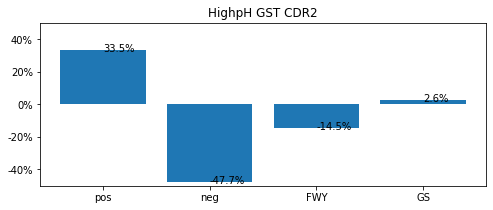

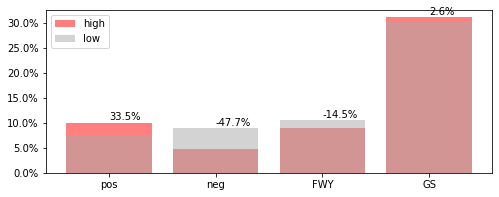

In [88]:

plt.figure(figsize=(8,3))
high = Unique_CDR2_HighpH[Unique_CDR2_HighpH['HighpH']=='2'][[aa+"_dens" for aa in 'YDSLGRAVTPEINFHCQWMK']].mean(0)
low = Unique_CDR2_HighpH[Unique_CDR2_HighpH['HighpH']=='0'][[aa+"_dens" for aa in 'YDSLGRAVTPEINFHCQWMK']].mean(0)
low['pos'] = low[['K_dens','R_dens','H_dens']].sum()
low['neg'] = low[['D_dens','E_dens']].sum()
low['FWY'] = low[['F_dens','W_dens','Y_dens']].sum()
low['GS'] =  low[['G_dens','S_dens']].sum()


high['pos'] = high[['K_dens','R_dens','H_dens']].sum()
high['neg'] = high[['D_dens','E_dens']].sum()
high['FWY'] = high[['F_dens','W_dens','Y_dens']].sum()
high['GS'] =  high[['G_dens','S_dens']].sum()



selected_low = low.loc[['pos','neg','FWY',"GS"]]
selected_aas_in_low = selected_low.index
selected_high = high.loc[selected_aas_in_low]

diff = ((selected_high-selected_low)/selected_low)
plt.bar(diff.index,diff.values)
plt.ylim((-0.5,0.5))
plt.title("HighpH GST CDR2")

for aa in diff.index:
    plt.text(aa,diff.loc[aa]-0.01,"{}%".format(round(100*diff.loc[aa],1)))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

#plt.savefig("Concentration_head_cdr3_percentage_change.svg",format='svg')


data = pd.DataFrame({"aa":selected_low.index,"high":selected_high.values,"low":selected_low.values})
data['diff'] = (data['high']-data['low'])/data['low']
#data.sort_values('diff',ascending=True,inplace=True)
#sns.barplot(x='aa',y='high',data=data,color='red',alpha=0.5,label='High')
#sns.barplot(x='aa',y='low',data=data,color='grey',alpha=0.5,label='Low')
plt.figure(figsize=(8,3))
plt.bar(data['aa'],data['high'],color='red',alpha=0.5,label='high')
plt.bar(data['aa'],data['low'],color='darkgrey',alpha=0.5,label='low')

for i,r in data.iterrows():
    plt.text(r['aa'],(r['high'] if r['high']>r['low'] else r['low'] )+0.005,"{}%".format(round(r['diff']*100,1)))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend()
plt.savefig("GST_Figures/AA_group_CDR2_Concentration.svg",format='svg')

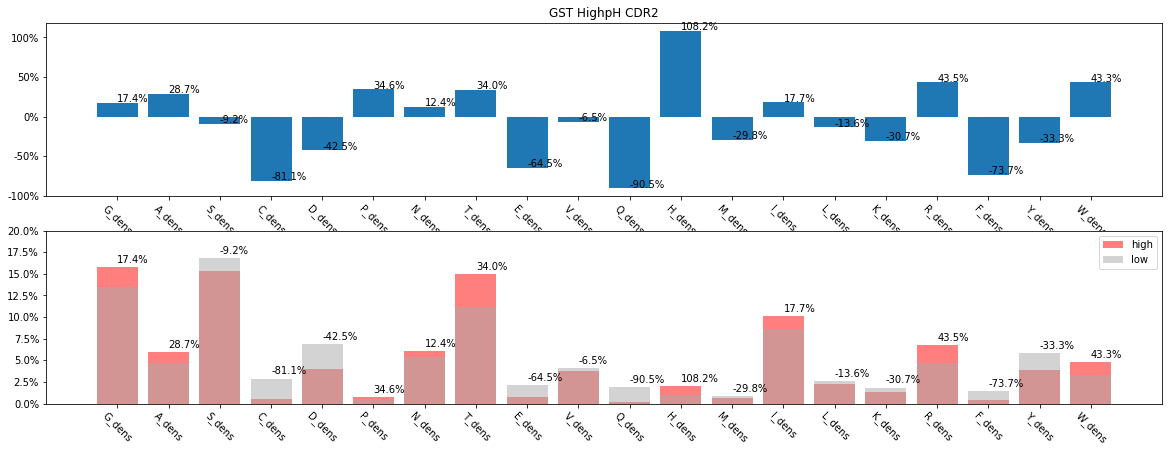

In [101]:

plt.figure(figsize=(20,7))
plt.subplot(211)
high = Unique_CDR2_HighpH[Unique_CDR2_HighpH['HighpH']=='2'][[aa+"_dens" for aa in 'GASCDPNTEVQHMILKRFYW']].mean(0)
low = Unique_CDR2_HighpH[Unique_CDR2_HighpH['HighpH']=='0'][[aa+"_dens" for aa in 'GASCDPNTEVQHMILKRFYW']].mean(0)
selected_low = low.loc[low.index.map(low>0)]
selected_aas_in_low = selected_low.index
selected_high = high.loc[selected_aas_in_low]

diff = ((selected_high-selected_low)/selected_low)
plt.bar(diff.index,diff.values)
for aa in diff.index:
    plt.text(aa,diff.loc[aa]+0.01,"{}%".format(round(100*diff.loc[aa],1)))
    
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(rotation=-45)
plt.title("GST HighpH CDR2")

data = pd.DataFrame({"aa":selected_low.index,"high":selected_high.values,"low":selected_low.values})
data['diff'] = (data['high']-data['low'])/data['low']
#data.sort_values('diff',ascending=True,inplace=True)
#sns.barplot(x='aa',y='high',data=data,color='red',alpha=0.5,label='High')
#sns.barplot(x='aa',y='low',data=data,color='grey',alpha=0.5,label='Low')
plt.subplot(212)
plt.bar(data['aa'],data['high'],color='red',alpha=0.5,label='high')
plt.bar(data['aa'],data['low'],color='darkgrey',alpha=0.5,label='low')

for i,r in data.iterrows():
    plt.text(r['aa'],(r['high'] if r['high']>r['low'] else r['low'] )+0.005,"{}%".format(round(r['diff']*100,1)))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.xticks(rotation=-45)
plt.ylim(ymax=0.2)

plt.legend()
plt.savefig("GST_Figures/AA_CDR2_Concentration.svg",format='svg')

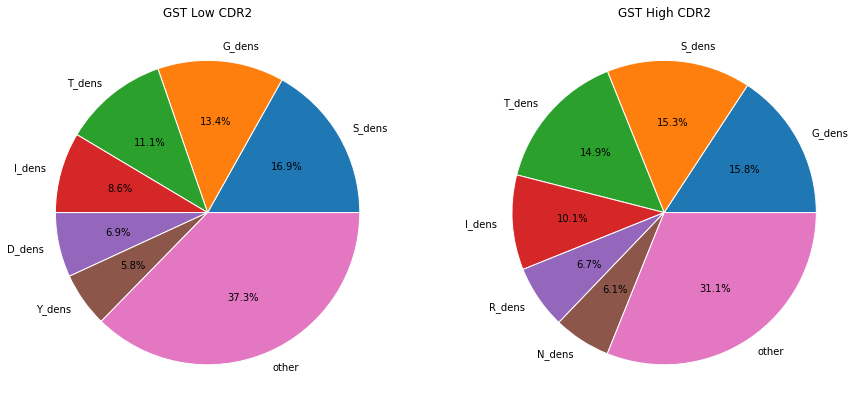

In [35]:
plt.figure(figsize=(15,8))
plt.subplot(121)
aa,aa_counts = counts_2(Unique_CDR2_HighpH[Unique_CDR2_HighpH['HighpH']=='0'])

plt.pie(
    list(aa_counts[:6]) + [aa_counts[6:].sum()],
    labels =list(aa[:6]) + ['other'],
    radius=1,
    wedgeprops=dict(width=1, edgecolor='w'),
autopct= "%1.1f%%")
plt.title("GST Low CDR2")
plt.subplot(122)
aa,aa_counts = counts_2(Unique_CDR2_HighpH[Unique_CDR2_HighpH['HighpH']=='2'])

plt.pie(
    list(aa_counts[:6]) + [aa_counts[6:].sum()],
    labels =list(aa[:6]) + ['other'],
    radius=1,
    wedgeprops=dict(width=1, edgecolor='w'),
autopct= "%1.1f%%")
plt.title("GST High CDR2")
plt.savefig("GST_Figures\PieChart GST CDR2 AA percentage.svg",format='svg')

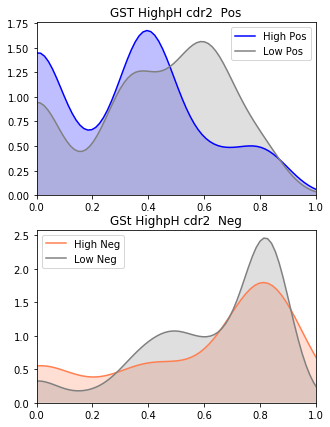

In [117]:


high_p=[]
high_n=[]

for cdr2 in Unique_CDR2_HighpH[Unique_CDR2_HighpH['HighpH']=='2']['CDR2']:
    if not ("R" in cdr2 or "K" in cdr2):
        continue
    pos = []
    for i in range(len(cdr2)-4):
            res = cdr2[i]
            if res =='K' or res =='R':
                pos.append(i/(len(cdr2)-4))

    high_p += pos
    
for cdr2 in Unique_CDR2_HighpH[Unique_CDR2_HighpH['HighpH']=='2']['CDR2']:
    if not ("D" in cdr2 or "E" in cdr2):
        continue
    pos = []
    for i in range(len(cdr2)-4):
            res = cdr2[i]
            if res =='D' or res =='E':
                pos.append(i/(len(cdr2)-4))

    high_n += pos
low_p=[]
low_n=[]

for cdr2 in Unique_CDR2_HighpH[Unique_CDR2_HighpH['HighpH']=='0']['CDR2']:
    if not ("R" in cdr2 or "K" in cdr2 ):
        continue
    pos = []
    for i in range(len(cdr2)-4):
            res = cdr2[i]
            if res =='K' or res =='R':
                pos.append(i/(len(cdr2)-4))

    low_p += pos
    
for cdr2 in Unique_CDR2_HighpH[Unique_CDR2_HighpH['HighpH']=='0']['CDR2']:
    if not ("D" in cdr2 or "E" in cdr2):
        continue
    pos = []
    for i in range(len(cdr2)-4):
            res = cdr2[i]
            if res =='D' or res =='E':
                pos.append(i/(len(cdr2)-4))

    low_n += pos
plt.figure(figsize=(5,7))
plt.subplot(211)
plt.title("GST HighpH cdr2  Pos")
sns.distplot(high_p,hist=False,label='High Pos',kde_kws={'shade':True},color='blue')
sns.distplot(low_p,hist=False,label='Low Pos',kde_kws={'shade':True},color='grey')

plt.xlim((0,1))
plt.subplot(212)
plt.title("GSt HighpH cdr2  Neg")
sns.distplot(high_n,hist=False,label='High Neg',kde_kws={'shade':True},color='coral')
sns.distplot(low_n,hist=False,label='Low Neg',kde_kws={'shade':True},color='grey')
plt.xlim((0,1))
plt.legend()
plt.savefig("GST_Figures\GST_Charge_cdr2_position.svg",format='svg')

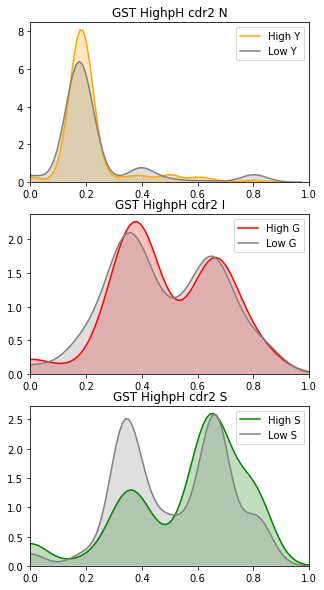

In [237]:
high_N=[]
high_I=[]
high_S=[]
for cdr2 in Unique_CDR2_HighpH[Unique_CDR2_HighpH['HighpH']=='2']['CDR2']:
    if not ("N" in cdr2):
        continue
    pos = []
    for i in range(len(cdr2)-4):
            res = cdr2[i]
            if res =='N':
                pos.append(i/(len(cdr2)-4))

    high_N += pos
for cdr2 in Unique_CDR2_HighpH[Unique_CDR2_HighpH['HighpH']=='2']['CDR2']:
    if not ("I" in cdr2):
        continue
    pos = []
    for i in range(len(cdr2)-4):
            res = cdr2[i]
            if res =='I':
                pos.append(i/(len(cdr2)-4))

    high_I += pos
for cdr2 in Unique_CDR2_HighpH[Unique_CDR2_HighpH['HighpH']=='2']['CDR2']:
    if not ("S" in cdr2):
        continue
    pos = []
    for i in range(len(cdr2)-4):
            res = cdr2[i]
            if res =='S':
                pos.append(i/(len(cdr2)-4))

    high_S += pos

low_N=[]
low_I=[]
low_S=[]

for cdr2 in Unique_CDR2_HighpH[Unique_CDR2_HighpH['HighpH']=='0']['CDR2']:
    if not ("N" in cdr2):
        continue
    pos = []
    for i in range(len(cdr2)-4):
            res = cdr2[i]
            if res =='N':
                pos.append(i/(len(cdr2)-4))

    low_N += pos
for cdr2 in Unique_CDR2_HighpH[Unique_CDR2_HighpH['HighpH']=='0']['CDR2']:
    if not ("I" in cdr2):
        continue
    pos = []
    for i in range(len(cdr2)-4):
            res = cdr2[i]
            if res =='I':
                pos.append(i/(len(cdr2)-4))

    low_I += pos
for cdr2 in Unique_CDR2_HighpH[Unique_CDR2_HighpH['HighpH']=='0']['CDR2']:
    if not ("S" in cdr2):
        continue
    pos = []
    for i in range(len(cdr2)-4):
            res = cdr2[i]
            if res =='S':
                pos.append(i/(len(cdr2)-4))

    low_S += pos

plt.figure(figsize=(5,10))
plt.subplot(311)
plt.title("GST HighpH cdr2 N")

sns.distplot(high_I,hist=False,label='High Y',kde_kws={'shade':True},color='orange')
sns.distplot(low_I,hist=False,label='Low Y',kde_kws={'shade':True},color='grey')

plt.xlim((0,1))
plt.subplot(312)
plt.title("GST HighpH cdr2 I")
sns.distplot(high_N,hist=False,label='High G',kde_kws={'shade':True},color='red')
sns.distplot(low_N,hist=False,label='Low G',kde_kws={'shade':True},color='grey')

plt.xlim((0,1))
plt.legend()
#plt.savefig("HSA_Figures\HSA_YGS_cdr2_head_position.svg",format='svg')
plt.subplot(313)
plt.title("GST HighpH cdr2 S")

sns.distplot(high_S,hist=False,label='High S',kde_kws={'shade':True},color='green')
sns.distplot(low_S,hist=False,label='Low S',kde_kws={'shade':True},color='grey')
plt.xlim((0,1))
plt.legend()
plt.savefig("GST_Figures\GST_NIS_CDR2_position.svg",format='svg')